In [ ]:
import torch
import os
import pandas as pd
from datetime import datetime
import time

In [ ]:
print(os.getcwd())

/content


In [ ]:
!pip install wandb -qU

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.0/241.0 kB 25.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.6 MB/s eta 0:00:00


In [ ]:
import wandb
# fc8b5ea957cf72c6563226b2ffc1ef01cde29bf0
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

# Data preparation

In [ ]:
data_path = "/content/drive/MyDrive/Đồ án model recommendation/data_youchoose"
os.listdir(data_path)
buy_data_path = 'yoochoose-buys.dat'


In [ ]:
buy_data = pd.read_csv(os.path.join(data_path, buy_data_path), names = ['SessionId', 'DateTime', 'ItemId', 'Price', 'Quantity'])
buy_data['DateTime'] = buy_data['DateTime'].apply(lambda x: datetime.strptime(x, '%Y-%m-%dT%H:%M:%S.%fZ'))
buy_data['Timestamp'] = buy_data['DateTime'].apply(lambda x: x.strftime('%s.%f'))
buy_data = buy_data.sort_values(by = ['SessionId', 'DateTime'], ascending = True)

In [ ]:
buy_data.head()

,SessionId,DateTime,ItemId,Price,Quantity,Timestamp
10,11,2014-04-03 11:04:11.417,214821371,1046,1,1396523051.417000
11,11,2014-04-03 11:04:18.097,214821371,1046,1,1396523058.097000
12,12,2014-04-02 10:42:17.227,214717867,1778,4,1396435337.227000
23,21,2014-04-07 09:24:18.307,214548744,3141,1,1396862658.307000
24,21,2014-04-07 09:24:18.360,214838503,18745,1,1396862658.360000


In [ ]:
buy_data['Quantity'].value_counts().sort_index()
buy_data.shape

(1150753, 6)

In [ ]:
x = buy_data
# x.head()
x = x.set_index('SessionId')
x.head()
# x.index
x = x[(x.index == 11) | (x.index == 12)]
x

,DateTime,ItemId,Price,Quantity,Timestamp
SessionId,,,,,
11,2014-04-03 11:04:11.417,214821371,1046,1,1396523051.417000
11,2014-04-03 11:04:18.097,214821371,1046,1,1396523058.097000
12,2014-04-02 10:42:17.227,214717867,1778,4,1396435337.227000


In [ ]:
# Thống kê số lượt xuất hiện và lọc ra các ItemId có trên 5 lượt xuất hiện
df_item_count = buy_data[['ItemId', 'SessionId']].groupby('ItemId').count().sort_values(by = 'SessionId', ascending = False)
df_item_count.columns = ['CountItemId']
df_item_count_5 = df_item_count[df_item_count['CountItemId'] < 5]
# Lọc khỏi dataset những ItemId có ít hơn 5 lượt xuất hiện
dataset = buy_data[~buy_data['ItemId'].isin(list(df_item_count_5.index))]
dataset.shape

(1132868, 6)

In [ ]:
from datetime import timedelta
# Phân chia tập train/test sao cho tập test là 7 ngày gần đây nhất và train là dữ liệu còn lại
maxdate = dataset['DateTime'].max()
print(maxdate)
mindate7 = maxdate - timedelta(days = 17)
test = dataset[dataset['DateTime'] >= mindate7]
dataset = dataset[dataset['DateTime'] <= mindate7]
print(test.shape)
print(dataset.shape)

2014-09-30 02:35:12.859000
(121743, 6)
(1011125, 6)


In [ ]:
import numpy as np

# list các sessionIds
sessIds = list(dataset['SessionId'].unique())
# Lấy ngẫu nhiên 1/4 số lượng các session
# n_filter = int(len(sessIds)/4)
n_filter = int(len(sessIds))
np.random.shuffle(sessIds)
sessIdsFilter = sessIds[:n_filter]
# Lựa chọn các 1/4 session làm dataset train (dữ liệu này bao gồm cả train và validation)
# Set index là sessionId để filter nhanh hơn
dataset.set_index('SessionId', inplace=True)
dataset_filter = dataset[dataset.index.isin(sessIdsFilter)]
dataset_filter = dataset_filter.reset_index()
dataset_filter.head()

,SessionId,DateTime,ItemId,Price,Quantity,Timestamp
0,11,2014-04-03 11:04:11.417,214821371,1046,1,1396523051.417000
1,11,2014-04-03 11:04:18.097,214821371,1046,1,1396523058.097000
2,12,2014-04-02 10:42:17.227,214717867,1778,4,1396435337.227000
3,21,2014-04-07 09:24:18.307,214548744,3141,1,1396862658.307000
4,21,2014-04-07 09:24:18.360,214838503,18745,1,1396862658.360000


In [ ]:
dataset_filter.shape

(886969, 6)

In [ ]:
# convert item id to 0 -> n
num_items = dataset_filter['ItemId'].unique().shape[0]

sorted_list = np.sort(dataset_filter['ItemId'].unique())
sorted_list

dataset_filter['ItemId'] = dataset_filter['ItemId'].apply(lambda x: np.where(sorted_list == x)[0][0])

In [ ]:
dataset_filter.head()

,SessionId,DateTime,ItemId,Price,Quantity,Timestamp
0,12,2014-04-02 10:42:17.227,214717867,1778,4,1396435337.227000
1,21,2014-04-07 09:24:18.307,214548744,3141,1,1396862658.307000
2,21,2014-04-07 09:24:18.360,214838503,18745,1,1396862658.360000
3,33,2014-04-06 18:24:51.206,214834865,523,2,1396808691.206000
4,33,2014-04-06 18:24:51.207,214706441,1360,1,1396808691.207000


In [ ]:
# Lấy ra dictionary có dạng {SessionId:{ItemId1:Timestamp1, ItemId2:Timestamp2, ...}}
train_sess = dataset_filter[['SessionId', 'ItemId', 'Timestamp']].groupby('SessionId').apply(lambda x: dict(zip(x['ItemId'], x['Timestamp'])))
test_sess = test[['SessionId', 'ItemId', 'Timestamp']].groupby('SessionId').apply(lambda x: dict(zip(x['ItemId'], x['Timestamp'])))

In [ ]:
train_sess.head()

SessionId
11                      {214821371: '1396523058.097000'}
87     {214652220: '1396853842.557000', 214840483: '1...
138                     {214594592: '1396605582.860000'}
197                     {214774685: '1396721945.047000'}
216                     {214821277: '1396461361.797000'}
dtype: object

In [ ]:
sessDict = {214834865: '1396808691.295000', 214706441: '1396808691.426000', 214820225: '1396808691.422000'}

def _preprocess_sess_dict(sessDict):
    sessDictTime = dict([(v, k) for (k, v) in sessDict.items()])
    sessSort = sorted(sessDictTime.items(), reverse = False)
    times = [item[0] for item in sessSort]
    itemIds = [item[1] for item in sessSort]
    inp_seq = []
    labels = []
    inp_time = []

    for i in range(len(sessSort)):
        if i >= 1:
            inp_seq += [itemIds[:i]]
            labels += [itemIds[i]]
            inp_time += [times[i]]
    return inp_seq, inp_time, labels, itemIds

inp_seq, inp_time, labels, itemIds = _preprocess_sess_dict(sessDict)
print('input sequences: ', inp_seq)
print('input times: ', inp_time)
print('targets: ', labels)
print('sequence: ', itemIds)

input sequences:  [[214834865], [214834865, 214820225]]
input times:  ['1396808691.422000', '1396808691.426000']
targets:  [214820225, 214706441]
sequence:  [214834865, 214820225, 214706441]


In [ ]:
def _preprocess_data(data_sess):
    inp_seqs = []
    inp_times = []
    labels = []
    sequences = []
    sessIds = list(data_sess.index)
    # print(len(sessIds))
    for sessId in sessIds:
        sessDict = data_sess.loc[sessId]
        inp_seq, inp_time, label, sequence = _preprocess_sess_dict(sessDict)
        inp_seqs += inp_seq
        inp_times += inp_time
        labels += label
        sequences += sequence
    # print(len(inp_seqs))
    return inp_seqs, inp_times, labels, sequences

train_inp_seqs, train_inp_dates, train_labs, train_sequences = _preprocess_data(train_sess)
test_inp_seqs, test_inp_dates, test_labs, test_sequences = _preprocess_data(test_sess)

train = (train_inp_seqs, train_labs)
test = (test_inp_seqs, test_labs)

print('Done.')

Done.


In [ ]:
# save data by pickle

import pickle
import os

def _save_file(filename, obj):
  with open(filename, 'wb') as fn:
    pickle.dump(obj, fn)

# Tạo folder yoochoose-data-4 để lưu dữ liệu train/test nếu chưa tồn tại
# if not os.path.exists('yoochoose-data/yoochoose-data-4'):
#   os.mkdir('yoochoose-data/yoochoose-data-4')

# Lưu train/test
# _save_file('/content/drive/MyDrive/Đồ án model recommendation/data_youchoose/full_data/train.pkl', train)
# _save_file('/content/drive/MyDrive/Đồ án model recommendation/data_youchoose/full_data/test.pkl', test)

_save_file('/content/drive/MyDrive/Đồ án model recommendation/data_youchoose/full_data_increase_test_sample/train.pkl', train)
_save_file('/content/drive/MyDrive/Đồ án model recommendation/data_youchoose/full_data_increase_test_sample/test.pkl', test)

In [ ]:
import pickle

# load pkl file

def _load_file(filename):
  with open(filename, 'rb') as fn:
    data = pickle.load(fn)
  return data

# Load dữ liệu train/test từ folder
# train = _load_file('/content/drive/MyDrive/Đồ án model recommendation/data_youchoose/full_data/train.pkl')
# test = _load_file('/content/drive/MyDrive/Đồ án model recommendation/data_youchoose/full_data/test.pkl')

train = _load_file('/content/drive/MyDrive/Đồ án model recommendation/data_youchoose/full_data_increase_test_sample/train.pkl')
test = _load_file('/content/drive/MyDrive/Đồ án model recommendation/data_youchoose/full_data_increase_test_sample/test.pkl')

# train = _load_file('/content/drive/MyDrive/Đồ án model recommendation/data_youchoose/train.pkl')
# test = _load_file('/content/drive/MyDrive/Đồ án model recommendation/data_youchoose/test.pkl')

In [ ]:
# max input sequence length
x1 = train[0]
l = [len(x) for x in x1]
print(max(l))
print(min(l))
print(len(x1))

51
1
457712


In [ ]:
len(test[0])

59509

In [ ]:
# Các token default
PAD_token = 0  # token padding cho câu ngắn ==> index = 0

# tạo Vocabulary for index input

class Voc:
    def __init__(self, name):
        self.name = name
        self.trimmed = False
        self.item2index = {}
        self.item2count = {}
        self.index2item = {PAD_token: "PAD"}
        self.num_items = 1  # số lượng mặc định ban đầu là 1 ứng với PAD_token

    def addSenquence(self, data):
        for sequence in data:
          for item in sequence:
              self.addItem(item)

    # Thêm một item vào hệ thống
    def addItem(self, item):
        if item not in self.item2index:
            self.item2index[item] = self.num_items
            self.item2count[item] = 1
            self.index2item[self.num_items] = item
            self.num_items += 1
        else:
            self.item2count[item] += 1

    # Loại các item dưới ngưỡng xuất hiện min_count
    def trim(self, min_count):
        if self.trimmed:
            return
        self.trimmed = True

        keep_items = []

        for k, v in self.item2count.items():
            if v >= min_count:
                keep_items.append(k)

        print('keep_items {} / {} = {:.4f}'.format(
            len(keep_items), len(self.item2index), len(keep_items) / len(self.item2index)
        ))

        # Khởi tạo lại từ điển
        self.item2index = {}
        self.item2count = {}
        self.index2item = {PAD_token: "PAD"}
        self.num_items = 1

        # Thêm các items vào từ điển
        for item in keep_items:
            self.addItem(item)

    # Hàm convert sequence về chuỗi các indices
    def _seqItem2seqIndex(self, x):
        return [self.item2index[item] if item in self.item2index else 0 for item in x]

In [ ]:
from itertools import chain
seq_targets = [train[1]] + [test[1]]
itemIds  = list(chain.from_iterable(seq_targets))
itemIds  = set(itemIds)
print('Number of itemIds : ', len(itemIds))
print(len(seq_targets[0]))

Number of itemIds :  9948
457712


In [ ]:
# tạo dict vocabuary data
voc = Voc('DictItemId')
voc.addSenquence(seq_targets)

# Convert thử nghiệm một sequence itemIds
print('sequence of itemIds: ', train[0][3])
print('converted indices: ', voc._seqItem2seqIndex(train[0][3]))

sequence of itemIds:  [214652220]
converted indices:  [1865]


In [ ]:
print(voc._seqItem2seqIndex([214840483]))
print(voc._seqItem2seqIndex([214826837]))

[4]
[6]


In [ ]:
print(voc.index2item.keys())

## Sequence data

In [ ]:
train_x_index = [voc._seqItem2seqIndex(seq) for seq in train[0]]
test_x_index = [voc._seqItem2seqIndex(seq) for seq in test[0]]
train_y_index = voc._seqItem2seqIndex(train[1])
test_y_index = voc._seqItem2seqIndex(test[1])
train_index = (train_x_index, train_y_index)
test_index = (test_x_index, test_y_index)

## Feature data


In [ ]:
# data about feature of items
'''
feature_data={
    1: [44, 55, 66],
    2: [34, 445, 665],
    3: [1278, 93, 30],
    4: [22222, 933, 930],
    5: [777, 983, 8830],
}
'''
import pandas as pd
import numpy as np

feature_data_raw = pd.read_csv('/content/drive/MyDrive/Đồ án model recommendation/data_youchoose/data_spotify_track.csv', usecols=['id', 'danceability', 'energy', 'valence', 'acousticness',
                                                                                                                                      'tempo', 'loudness', 'liveness', 'speechiness'])

print(feature_data_raw.shape)

print(feature_data_raw.head())


(170653, 9)
   valence  acousticness  danceability  energy                      id  \
0   0.0594         0.982         0.279   0.211  4BJqT0PrAfrxzMOxytFOIz   
1   0.9630         0.732         0.819   0.341  7xPhfUan2yNtyFG0cUWkt8   
2   0.0394         0.961         0.328   0.166  1o6I8BglA6ylDMrIELygv1   
3   0.1650         0.967         0.275   0.309  3ftBPsC5vPBKxYSee08FDH   
4   0.2530         0.957         0.418   0.193  4d6HGyGT8e121BsdKmw9v6   

   liveness  loudness  speechiness    tempo  
0     0.665   -20.096       0.0366   80.954  
1     0.160   -12.441       0.4150   60.936  
2     0.101   -14.850       0.0339  110.339  
3     0.381    -9.316       0.0354  100.109  
4     0.229   -10.096       0.0380  101.665  


In [ ]:
feature_data_filter = feature_data_raw.sample(frac=0.1)
feature_data_filter.shape

(17065, 9)

In [ ]:
feature_data_filter.head()

,valence,acousticness,danceability,energy,id,liveness,loudness,speechiness,tempo
104239,0.513,0.0354,0.466,0.838,1CP8UCFq3Buyg4MN8mZUka,0.3400,-6.258,0.2480,99.816
27380,0.666,0.7980,0.418,0.445,4aWWhnZ3izYAfmmCSOkqlM,0.1070,-8.690,0.0301,95.974
118536,0.788,0.0660,0.642,0.979,58nnHo2vaWBX7LKU0kMxFv,0.0259,-4.102,0.0462,110.026
99504,0.752,0.0508,0.556,0.758,1v0PatOEeF1g1fVRNlmw9k,0.2840,-14.826,0.0366,127.897
34900,0.570,0.0266,0.622,0.669,0jG92AlXau21qgCQRxGLic,0.1520,-8.419,0.3290,93.839


In [ ]:
feature_data_filter.nunique()

valence          1355
acousticness     2890
danceability      927
energy           1606
id              17065
liveness         1517
loudness        11199
speechiness      1344
tempo           15464
dtype: int64

In [ ]:
# convert item id to 0 -> n
feature_data_filter['id'] = range(1, 17066)

In [ ]:
feature_data_filter.head()

,valence,acousticness,danceability,energy,id,liveness,loudness,speechiness,tempo
156550,0.480,0.8730,0.720,0.793,1,0.4750,-10.372,0.0476,127.200
35110,0.412,0.4710,0.558,0.687,2,0.0958,-8.634,0.0381,94.989
28426,0.429,0.0898,0.240,0.546,3,0.0898,-10.026,0.0548,181.373
6753,0.411,0.8540,0.374,0.208,4,0.4560,-14.159,0.0367,151.867
40460,0.565,0.9770,0.453,0.622,5,0.5050,-7.977,0.0567,126.793


In [ ]:
# save data raw by pickle
feature_data_filter.to_pickle('/content/drive/MyDrive/Đồ án model recommendation/data_youchoose/data_spotify_track_feature_raw.pkl')

In [ ]:
# load data raw from pkl file
feature_data_filter = pd.read_pickle('/content/drive/MyDrive/Đồ án model recommendation/data_youchoose/data_spotify_track_feature_raw.pkl')
feature_data_filter.head()

,valence,acousticness,danceability,energy,id,liveness,loudness,speechiness,tempo
156550,0.480,0.8730,0.720,0.793,1,0.4750,-10.372,0.0476,127.200
35110,0.412,0.4710,0.558,0.687,2,0.0958,-8.634,0.0381,94.989
28426,0.429,0.0898,0.240,0.546,3,0.0898,-10.026,0.0548,181.373
6753,0.411,0.8540,0.374,0.208,4,0.4560,-14.159,0.0367,151.867
40460,0.565,0.9770,0.453,0.622,5,0.5050,-7.977,0.0567,126.793


In [ ]:
# Scaler
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()

feature_data_filter[['danceability', 'energy', 'valence', 'acousticness', 'tempo', 'loudness', 'liveness', 'speechiness']] = std_scaler.fit_transform(feature_data_filter[['danceability', 'energy', 'valence', 'acousticness', 'tempo', 'loudness', 'liveness', 'speechiness']])

feature_data_filter=feature_data_filter.round(4)
feature_data_filter.head()

,valence,acousticness,danceability,energy,id,liveness,loudness,speechiness,tempo
156550,-0.1877,0.9820,1.0387,1.1645,1,1.5556,0.1899,-0.3149,0.3312
35110,-0.4466,-0.0832,0.1167,0.7675,2,-0.6288,0.4973,-0.3740,-0.7169
28426,-0.3819,-1.0933,-1.6932,0.2394,3,-0.6634,0.2511,-0.2702,2.0938
6753,-0.4504,0.9316,-0.9305,-1.0266,4,1.4461,-0.4799,-0.3827,1.1338
40460,0.1359,1.2575,-0.4809,0.5240,5,1.7284,0.6135,-0.2583,0.3179


In [ ]:
# Save data processed
feature_data_filter.to_pickle('/content/drive/MyDrive/Đồ án model recommendation/data_youchoose/data_spotify_track_feature_processed.pkl')

In [ ]:
# load data processed from pkl file
feature_data_filter = pd.read_pickle('/content/drive/MyDrive/Đồ án model recommendation/data_youchoose/data_spotify_track_feature_processed.pkl')
feature_data_filter.head()

,valence,acousticness,danceability,energy,id,liveness,loudness,speechiness,tempo
156550,-0.1877,0.9820,1.0387,1.1645,1,1.5556,0.1899,-0.3149,0.3312
35110,-0.4466,-0.0832,0.1167,0.7675,2,-0.6288,0.4973,-0.3740,-0.7169
28426,-0.3819,-1.0933,-1.6932,0.2394,3,-0.6634,0.2511,-0.2702,2.0938
6753,-0.4504,0.9316,-0.9305,-1.0266,4,1.4461,-0.4799,-0.3827,1.1338
40460,0.1359,1.2575,-0.4809,0.5240,5,1.7284,0.6135,-0.2583,0.3179


In [ ]:
# Get feature data dict: {id: feature_data}
feature_data = feature_data_filter.set_index('id').T.to_dict('list')
feature_data

{1: [-0.1877, 0.982, 1.0387, 1.1645, 1.5556, 0.1899, -0.3149, 0.3312],
 2: [-0.4466, -0.0832, 0.1167, 0.7675, -0.6288, 0.4973, -0.374, -0.7169],
 3: [-0.3819, -1.0933, -1.6932, 0.2394, -0.6634, 0.2511, -0.2702, 2.0938],
 4: [-0.4504, 0.9316, -0.9305, -1.0266, 1.4461, -0.4799, -0.3827, 1.1338],
 5: [0.1359, 1.2575, -0.4809, 0.524, 1.7284, 0.6135, -0.2583, 0.3179],
 6: [0.8022, 1.3052, 0.0484, -1.0041, 0.5417, -0.4445, 0.5769, 1.8741],
 7: [-1.8043, 1.0376, -2.5685, -1.1877, -0.774, -1.2786, -0.3821, 1.6316],
 8: [-0.1001, 0.7488, 0.1963, 0.1307, -0.1668, 0.0404, -0.425, -1.3084],
 9: [0.6423, -1.1001, -0.4183, 0.8087, 0.1673, 0.6067, -0.351, -0.3659],
 10: [-1.0367, 1.3052, -1.1297, -1.5659, 0.6281, -2.6494, -0.3411, -0.2733],
 11: [0.49, 1.284, -0.3045, 0.2056, -0.0286, 0.16, -0.4088, 0.2518],
 12: [1.6588, -1.3299, 1.3858, 0.7338, -0.827, 0.3936, -0.2129, -1.3335],
 13: [0.1968, -1.3306, 1.346, 0.1644, -0.907, -1.0391, -0.0214, 1.0112],
 14: [-1.1624, 0.513, 0.7655, -0.8393, -0.5873, 

In [ ]:
# convert item id to 0 -> n
num_items = dataset_filter['ItemId'].unique().shape[0]

sorted_list = np.sort(dataset_filter['ItemId'].unique())
sorted_list

dataset_filter['ItemId'] = dataset_filter['ItemId'].apply(lambda x: np.where(sorted_list == x)[0][0])

# Dataset


In [ ]:
def load_data(root='', valid_portion=0.1, maxlen=19, sort_by_len=False, train_set=None, test_set=None):
    """Load dataset từ root
    root: folder dữ liệu train, trong trường hợp train_set, test_set tồn tại thì không sử dụng train_set và test_set
    valid_portion: tỷ lệ phân chia dữ liệu validation/train
    maxlen: độ dài lớn nhất của sequence
    sort_by_len: có sort theo chiều dài các session trước khi chia hay không?
    train_set: training dataset
    test_set:  test dataset
    """

    # Load the dataset
    if train_set is None and test_set is None:
        path_train_data = os.path.join(root, 'train.pkl')
        path_test_data = os.path.join(root, 'test.pkl')
        with open(path_train_data, 'rb') as f1:
            train_set = pickle.load(f1)

        with open(path_test_data, 'rb') as f2:
            test_set = pickle.load(f2)

    if maxlen:
        new_train_set_x = []
        new_train_set_y = []
        # Lọc dữ liệu sequence đến maxlen
        for x, y in zip(train_set[0], train_set[1]): # x = [214652220], y = 214840483
            if len(x) < maxlen:
                new_train_set_x.append(x)
                new_train_set_y.append(y)
            else:
                new_train_set_x.append(x[:maxlen])
                new_train_set_y.append(y)
        train_set = (new_train_set_x, new_train_set_y)
        del new_train_set_x, new_train_set_y

        new_test_set_x = []
        new_test_set_y = []
        for xx, yy in zip(test_set[0], test_set[1]):
            if len(xx) < maxlen:
                new_test_set_x.append(xx)
                new_test_set_y.append(yy)
            else:
                new_test_set_x.append(xx[:maxlen])
                new_test_set_y.append(yy)
        test_set = (new_test_set_x, new_test_set_y)
        del new_test_set_x, new_test_set_y

    # phân chia tập train thành train và validation
    train_set_x, train_set_y = train_set
    n_samples = len(train_set_x)
    sidx = np.arange(n_samples, dtype='int32')
    np.random.shuffle(sidx)
    n_train = int(np.round(n_samples * (1. - valid_portion)))
    valid_set_x = [train_set_x[s] for s in sidx[n_train:]]
    valid_set_y = [train_set_y[s] for s in sidx[n_train:]]
    train_set_x = [train_set_x[s] for s in sidx[:n_train]]
    train_set_y = [train_set_y[s] for s in sidx[:n_train]]

    (test_set_x, test_set_y) = test_set

    # Trả về indices thứ tự độ dài của mỗi phần tử trong seq
    def len_argsort(seq):
        return sorted(range(len(seq)), key=lambda x: len(seq[x]))
    '''
        len_argsort([[1, 2, 3, 4], [1], [1, 2, 3, 4, 5, 6]])
        ==> [1, 0, 2]
    '''

    # Sắp xếp session theo độ dài tăng dần
    if sort_by_len:
        sorted_index = len_argsort(test_set_x)
        test_set_x = [test_set_x[i] for i in sorted_index]
        test_set_y = [test_set_y[i] for i in sorted_index]

        sorted_index = len_argsort(valid_set_x)
        valid_set_x = [valid_set_x[i] for i in sorted_index]
        valid_set_y = [valid_set_y[i] for i in sorted_index]

    train = (train_set_x, train_set_y)
    valid = (valid_set_x, valid_set_y)
    test = (test_set_x, test_set_y)
    return train, valid, test

In [ ]:
# Dataset
from torch.utils.data import Dataset

class RecSysDataset(Dataset):
    """define the pytorch Dataset class for yoochoose and diginetica datasets.
    """
    def __init__(self, data):
        self.data = data
        print('-'*50)
        print('Dataset info:')
        print('Number of sessions: {}'.format(len(data[0])))
        print('-'*50)

    def __getitem__(self, index):
        session_items = self.data[0][index]
        target_item = self.data[1][index]
        return session_items, target_item

    def __len__(self):
        return len(self.data[0])

In [ ]:
import torch
from torch.nn.utils.rnn import pad_sequence

def collate_fn(data):
    """
    Hàm số này sẽ được sử dụng để pad session về max length
    Args:
      data: batch truyền vào
    return:
      batch data đã được pad length có shape maxlen x batch_size
    """
    # Sort batch theo độ dài của input_sequence từ cao xuống thấp
    data.sort(key=lambda x: len(x[0]), reverse=True)
    lens = [len(sess) for sess, label in data]
    labels = []
    # Padding batch size
    # padded_sesss = torch.zeros(len(data), max(lens)).long()
    # for i, (sess, label) in enumerate(data):
    #     padded_sesss[i,:lens[i]] = torch.LongTensor(sess)
    #     labels.append(label)

    # print(padded_sesss)
    inputs = []
    for s, l in data:
      inputs.append(torch.LongTensor(s))
      labels.append(l)
    padded_sesss = pad_sequence(inputs)


    # Transpose dữ liệu từ batch_size x maxlen --> maxlen x batch_size
    # padded_sesss = padded_sesss.transpose(0,1)
    return padded_sesss, torch.tensor(labels).long(), lens

In [ ]:
def add_dense_feature(input_seq, embeddings, num_features):
  """
  input_seq: (maxlen x batch_size)
  embeddings:  embeddings to add dense feature ==> (max_length , batch_size , hidden_size)
  """

  input_expand = input_seq.view(-1, 1).expand(-1, num_features).clone().float()
  # print("input_expand = ", input_expand)
  for i, input_item in enumerate(input_seq.flatten()):
    if input_item.item() == 0:
        # print("input_item = ", input_item)
        # print(type(input_item.item()))
        continue
    input_expand[i] = torch.tensor(feature_data.get(input_item.item(), [0]*num_features))
    # print("get feature:", input_expand[i])

  input_expand = input_expand.view(input_seq.shape[0], input_seq.shape[1], num_features)
  outputs = torch.cat((input_expand, embeddings), 2)
  new_hidden_size = embeddings.shape[2] + num_features

  return outputs, new_hidden_size

In [ ]:
# item_embs = self.embedding(item_indices) # n_items x embedding_dim
# # reduce dimension by bi-linear projection
# B = self.b(item_embs).permute(1, 0) # (2*hidden_size) x n_items
# scores = torch.matmul(c_t, B) # batch_size x n_items
# # scores = self.sf(scores)
# return scores

i_seq = torch.tensor([1, 2, 3, 4, 5, 6, 7, 8, 9, 92737])

i_seq=i_seq.unsqueeze(1)
print(i_seq)
print(i_seq.shape)

embed = torch.ones(10, 1, 1)
print(embed)
print("---------")
o, n = add_dense_feature(i_seq, embed, 8)
print(o)
print(o.dtype)
print(o.shape)
print(n)

print(o.squeeze(1)[0])

In [ ]:
data =  [ [[1, 2, 3], [1]], [[1], [3]] ]

feature_data={
    1: [44, 55, 66],
    2: [34, 445, 665],
    3: [1278, 93, 30],
    4: [22222, 933, 930],
    5: [777, 983, 8830],
}

# print(data)
# data.sort(key=lambda x: len(x[0]), reverse=False)

# print(data)
print("---------")
x = collate_fn(data)
input_seq = x[0]
print("input_seq:",input_seq)
print(input_seq.shape)
print("input_seq.view(-1, 1): ",input_seq.view(-1, 1))
print(input_seq.view(-1, 1).shape)
print("---------")

x1 = input_seq.view(-1, 1).expand(-1, 3).clone()
print("x1:", x1)
print("x1:", x1.shape)

print("for loopp -------")
for i, xx1 in enumerate(input_seq.flatten()):
    if xx1 == 0:
        continue
    x1[i] = torch.tensor(feature_data[xx1.item()])

print("x1 after:", x1)
print("x1 after:", x1.shape)

print("---------")
x1 = x1.view(3,2, 3)
x2 = torch.tensor([[[  989],
         [  888]],

        [[  344],
         [   33]],

        [[1278],
         [   0]]]
)
print("x1 after:", x1)
print(x1.shape)


x1 = torch.cat((x1, x2), 2)
print("x1 after cat:", x1)
print(x1.shape)

print(x1.permute(1,0,2))


---------
input_seq: tensor([[1, 1],
        [2, 0],
        [3, 0]])
torch.Size([3, 2])
input_seq.view(-1, 1):  tensor([[1],
        [1],
        [2],
        [0],
        [3],
        [0]])
torch.Size([6, 1])
---------
x1: tensor([[1, 1, 1],
        [1, 1, 1],
        [2, 2, 2],
        [0, 0, 0],
        [3, 3, 3],
        [0, 0, 0]])
x1: torch.Size([6, 3])
for loopp -------
x1 after: tensor([[  44,   55,   66],
        [  44,   55,   66],
        [  34,  445,  665],
        [   0,    0,    0],
        [1278,   93,   30],
        [   0,    0,    0]])
x1 after: torch.Size([6, 3])
---------
x1 after: tensor([[[  44,   55,   66],
         [  44,   55,   66]],

        [[  34,  445,  665],
         [   0,    0,    0]],

        [[1278,   93,   30],
         [   0,    0,    0]]])
torch.Size([3, 2, 3])
x1 after cat: tensor([[[  44,   55,   66,  989],
         [  44,   55,   66,  888]],

        [[  34,  445,  665,  344],
         [   0,    0,    0,   33]],

        [[1278,   93,   30, 127

# Model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

In [ ]:
class NARM(nn.Module):
    def __init__(self, hidden_size, n_items, embedding_dim, n_layers=1, dropout=0.25):
        super(NARM, self).__init__()
        self.hidden_size = hidden_size
        self.n_items = n_items
        self.embedding_dim = embedding_dim
        self.n_layers = n_layers
        self.embedding = nn.Embedding(self.n_items, self.embedding_dim, padding_idx = 0)
        # Initialize GRU; the input_size and hidden_size params are both set to 'hidden_size'
        # set bidirectional = True for bidirectional
        self.gru = nn.GRU(input_size = hidden_size, # number of expected feature of input x
                          hidden_size = hidden_size, # number of expected feature of hidden state
                          num_layers = n_layers, # number of GRU layers
                          dropout=(0 if n_layers == 1 else dropout), # dropout probability apply in encoder network
                          bidirectional=True # one or two directions.
                         )
        self.emb_dropout = nn.Dropout(dropout)
        self.gru = nn.GRU(self.embedding_dim, self.hidden_size, self.n_layers)
        self.a_1 = nn.Linear(self.hidden_size, self.hidden_size, bias=False)
        self.a_2 = nn.Linear(self.hidden_size, self.hidden_size, bias=False)
        self.v_t = nn.Linear(self.hidden_size, 1, bias=False)
        self.ct_dropout = nn.Dropout(0.5)
        self.b = nn.Linear(self.embedding_dim, 2 * self.hidden_size, bias=False)
        self.sf = nn.Softmax()
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    def forward(self, input_seq, input_lengths, hidden=None):
        """
        input_seq: Batch input_sequence. Shape: max_len x batch_size
        input_lengths: Batch input lengths. Shape: batch_size
        """
        # Step 1: Convert sequence indexes to embeddings
        # shape: (max_length , batch_size , hidden_size)
        embedded = self.embedding(input_seq)
        print("embedded :", embedded.shape)
        print(embedded)
        # Pack padded batch of sequences for RNN module. Padding zero when length less than max_length of input_lengths.
        # shape: (total_lengths , hidden_size)
        packed = pack_padded_sequence(embedded, input_lengths)
        print("packed :", packed.data.shape)
        print("packed :", packed.batch_sizes)


        # Step 2: Forward packed through GRU
        # outputs is output of final GRU layer
        # hidden is concatenate of all hidden states corresponding with each time step.
        # outputs shape: (max_length , batch_size , hidden_size x num_directions)
        # hidden shape: (n_layers x num_directions , batch_size , hidden_size)
        outputs, hidden = self.gru(packed, hidden)
        print("outputs :", outputs.data.shape)
        print("hidden :", hidden.shape)

        # Unpack padding. Revert of pack_padded_sequence
        # outputs shape: (max_length , batch_size , hidden_size x num_directions)
        outputs, length = pad_packed_sequence(outputs)
        print("outputs :", outputs.shape)
        print("length :", length)

        # Step 3: Global Encoder & Local Encoder
        # num_directions = 1 -->
        # outputs shape:(max_length , batch_size , hidden_size)
        # hidden shape: (n_layers , batch_size , hidden_size)
        # lấy hidden state tại time step cuối cùng
        ht = hidden[-1] # (batch_size, hidden_size)
        print("ht :", ht.shape)
        # reshape outputs
        outputs = outputs.permute(1, 0, 2) # [batch_size, max_length, hidden_size]
        c_global = ht
        # Flatten outputs thành shape: [batch_size * max_length, hidden_size]
        gru_output_flatten = outputs.contiguous().view(-1, self.hidden_size)
        # Thực hiện một phép chiếu linear projection để tạo các latent variable có shape [batch_size, max_length, hidden_size]
        q1 = self.a_1(gru_output_flatten).view(outputs.size())
        print("q1:", q1)
        # Thực hiện một phép chiếu linear projection để tạo các latent variable có shape [batch_size, max_length, hidden_size]
        q2 = self.a_2(ht) # (batch_size, hidden_size)
        print("q2: ", q2)
        # Ma trận mask đánh dấu vị trí khác 0 trên padding sequence.
        mask = torch.where(input_seq.permute(1, 0) > 0, torch.tensor([1.], device = self.device), torch.tensor([0.], device = self.device)) # batch_size x max_len
        # Điều chỉnh shape
        q2_expand = q2.unsqueeze(1).expand_as(q1) # shape [batch_size, max_len, hidden_size]
        q2_masked = mask.unsqueeze(2).expand_as(q1) * q2_expand # batch_size x max_len x hidden_size
        print("q2_masked :", q2_masked)
        # Tính trọng số alpha đo lường similarity giữa các hidden state
        alpha = self.v_t(torch.sigmoid(q1 + q2_masked).view(-1, self.hidden_size)).view(mask.size()) # batch_size x max_len
        alpha_exp = alpha.unsqueeze(2).expand_as(outputs) # batch_size x max_len x hidden_size
        print("alpha_exp :", alpha_exp)
        # Tính linear combinition của các hidden state
        c_local = torch.sum(alpha_exp * outputs, 1) # (batch_size x hidden_size)

        # Véc tơ combinition tổng hợp
        c_t = torch.cat([c_local, c_global], 1) # batch_size x (2*hidden_size)
        c_t = self.ct_dropout(c_t)
        # Tính scores

        # Step 4: Decoder
        # embedding cho toàn bộ các item
        item_indices = torch.arange(self.n_items).to(device) # n_items
        item_embs = self.embedding(item_indices) # n_items x embedding_dim
        # reduce dimension by bi-linear projection
        B = self.b(item_embs).permute(1, 0) # (2*hidden_size) x n_items
        scores = torch.matmul(c_t, B) # batch_size x n_items
        # scores = self.sf(scores)
        return scores

## test

In [ ]:
ab = torch.arange(10)
print(ab.shape)

torch.Size([10])


In [ ]:
y = torch.tensor([[1],[2],[3],[4],[5],[6],[7],[8],[9] ])
print(y.shape)
y1 =y.view(3,3)
print(y1)
print("-----")

y2 = torch.tensor([
    [
      [1, 2, 3], [4, 5, 6]
    ],
       [[11, 22, 33], [44, 551, 16]
]
])
print(y2.shape)
print(y2)
y3 = torch.sum(y2, axis=1)
print(y3)

y4 = torch.tensor([
    [
      [1, 2, 3], [4, 5, 6]
    ],
       [[11, 22, 33], [44, 551, 16]
]
])
print(y2*y4)

torch.Size([9, 1])
tensor([[1, 2, 3],
        [4, 5, 6],
        [7, 8, 9]])
-----
torch.Size([2, 2, 3])
tensor([[[  1,   2,   3],
         [  4,   5,   6]],

        [[ 11,  22,  33],
         [ 44, 551,  16]]])
tensor([[  5,   7,   9],
        [ 55, 573,  49]])
tensor([[[     1,      4,      9],
         [    16,     25,     36]],

        [[   121,    484,   1089],
         [  1936, 303601,    256]]])


In [ ]:
x = torch.tensor([[1, 2], [0, 4]])

y = torch.tensor([[5, 4], [1, 3]])

(x+y)

tensor([[6, 6],
        [1, 7]])

In [ ]:
x = torch.tensor([[1, 1],
        [2, 1],
        [3, 0]])
print(x.shape)
print(x[-1].unsqueeze(1).shape)
x1 = x.permute(1, 0)
print(x1)
print(x1.shape)
mask = torch.where(x1 > 0, torch.tensor([1.]), torch.tensor([0.]))
print("-----")
print(mask)
print(mask.shape)
print("-----")

mask_2 = mask.unsqueeze(2).expand(2, 3, 4)
print(mask_2)
print(mask_2.shape)

torch.Size([3, 2])
torch.Size([2, 1])
tensor([[1, 2, 3],
        [1, 1, 0]])
torch.Size([2, 3])
-----
tensor([[1., 1., 1.],
        [1., 1., 0.]])
torch.Size([2, 3])
-----
tensor([[[1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.]],

        [[1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [0., 0., 0., 0.]]])
torch.Size([2, 3, 4])


In [ ]:
x = [
    [[6, 9, 8], [12, 5, 8], [7, 3, 2], [0, 0 , 0]],
    [[65, 95, 85], [121, 53, 28], [71, 33, 22], [10, 30 , 60]]
]

x = torch.tensor(x)
print("x shape:",x.shape)

x1 = x[-1]
print("x1 shape:", x1.shape)
print(x1.unsqueeze(1))
print(x1.unsqueeze(1).shape)

print("------")

x2 = x1.unsqueeze(1).expand_as(x.permute(1,0,2))
print("--------")
print(x2)
print(x2.shape)

# x1 = x.view(-1, 3)

# print(x1.shape)
# print(x1)

x shape: torch.Size([2, 4, 3])
x1 shape: torch.Size([4, 3])
tensor([[[ 65,  95,  85]],

        [[121,  53,  28]],

        [[ 71,  33,  22]],

        [[ 10,  30,  60]]])
torch.Size([4, 1, 3])
------
--------
tensor([[[ 65,  95,  85],
         [ 65,  95,  85]],

        [[121,  53,  28],
         [121,  53,  28]],

        [[ 71,  33,  22],
         [ 71,  33,  22]],

        [[ 10,  30,  60],
         [ 10,  30,  60]]])
torch.Size([4, 2, 3])


## exp

In [ ]:
# Thử nghiệm model bằng cách giả lập 1 input và thực hiện quá trình feed forward
from torch import nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
hidden_size = 3
n_layers = 7
# embedding = nn.Embedding(11000, hidden_size)
input_variable = torch.tensor([[  1,  2,   3, 4],
                                [ 5,  1,   2,  3],
                                [ 1, 3, 3,  4],
                                [ 4,   3,   0, 0],
                                [   1,    0,    0,    0]]).to(device)

lengths =  torch.tensor([5, 4, 3, 3]).to(device)
print('input_seq: \n', input_variable)
print('input_lengths: \n', lengths)
model_test = NARM(hidden_size = hidden_size, n_items  = 100000, num_features=8, embedding_dim = 100, n_layers=1, dropout=0.25).to(device)
print('model phrase: \n', model_test)
scores = model_test.forward(input_seq = input_variable, input_lengths = lengths)
print('probability distribution: ', scores.shape)

input_seq: 
 tensor([[1, 2, 3, 4],
        [5, 1, 2, 3],
        [1, 3, 3, 4],
        [4, 3, 0, 0],
        [1, 0, 0, 0]])
input_lengths: 
 tensor([5, 4, 3, 3])
model phrase: 
 NARM(
  (embedding): Embedding(100000, 100, padding_idx=0)
  (emb_dropout): Dropout(p=0.25, inplace=False)
  (gru): GRU(108, 3)
  (a_1): Linear(in_features=3, out_features=3, bias=False)
  (a_2): Linear(in_features=3, out_features=3, bias=False)
  (v_t): Linear(in_features=3, out_features=1, bias=False)
  (ct_dropout): Dropout(p=0.5, inplace=False)
  (b): Linear(in_features=108, out_features=6, bias=False)
  (sf): Softmax(dim=None)
)
embedded:  tensor([[[-0.6149, -1.3129, -0.6125,  ..., -0.9758, -1.1365,  0.6212],
         [-1.9414,  1.1400, -0.5760,  ..., -1.0128, -0.7389,  1.4835],
         [ 1.1181, -1.4342,  0.7697,  ..., -0.7928,  0.5217, -0.6289],
         [ 1.8246, -0.2249,  0.8904,  ..., -1.3440, -0.3484,  0.2367]],

        [[-1.5068, -0.8752, -0.5216,  ...,  0.5684,  0.1261, -0.5755],
         [-0.614

# concate other feature

In [ ]:
class NARM(nn.Module):
    def __init__(self, hidden_size, n_items, embedding_dim, num_features, n_layers=1, dropout=0.25):
        super(NARM, self).__init__()
        self.hidden_size = hidden_size
        self.n_items = n_items
        self.embedding_dim = embedding_dim
        self.n_layers = n_layers
        self.embedding = nn.Embedding(self.n_items, self.embedding_dim, padding_idx = 0)
        self.num_features = num_features
        # Initialize GRU; the input_size and hidden_size params are both set to 'hidden_size'
        # set bidirectional = True for bidirectional
        # self.gru = nn.GRU(input_size = hidden_size, # number of expected feature of input x
        #                   hidden_size = hidden_size, # number of expected feature of hidden state
        #                   num_layers = n_layers, # number of GRU layers
        #                   dropout=(0 if n_layers == 1 else dropout), # dropout probability apply in encoder network
        #                   bidirectional=True # one or two directions.
        #                  )
        self.emb_dropout = nn.Dropout(dropout)
        self.gru = nn.GRU(self.embedding_dim + self.num_features, self.hidden_size, self.n_layers)
        self.a_1 = nn.Linear(self.hidden_size, self.hidden_size, bias=False)
        self.a_2 = nn.Linear(self.hidden_size, self.hidden_size, bias=False)
        self.v_t = nn.Linear(self.hidden_size, 1, bias=False)
        self.ct_dropout = nn.Dropout(0.5)
        self.b = nn.Linear(self.embedding_dim + self.num_features, 2 * self.hidden_size, bias=False)
        self.sf = nn.Softmax()
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    def forward(self, input_seq, input_lengths, hidden=None):
        """
        input_seq: Batch input_sequence. Shape: max_len x batch_size
        input_lengths: Batch input lengths. Shape: batch_size
        """
        # Step 1: Convert sequence indexes to embeddings
        # shape: (max_length , batch_size , hidden_size)
        embedded = self.embedding(input_seq)
        # print("embedded: ", embedded)
        # Step 1.2: add item dense feature
        embedded, new_hidden_size = add_dense_feature(input_seq, embedded, self.num_features)
        # self.hidden_size=new_hidden_size

        # input_lengths = [il + 3 for il in input_lengths]
        # print("embedded after: ", embedded)
        # print("embedded :", embedded.shape)
        # print("input_lengths :", input_lengths)
        # Pack padded batch of sequences for RNN module. Padding zero when length less than max_length of input_lengths.
        # shape: (total_lengths , hidden_size)
        packed = pack_padded_sequence(embedded, input_lengths)
        # print("packed :", packed.data.shape)
        # print("packed :", packed.batch_sizes)


        # Step 2: Forward packed through GRU
        # outputs is output of final GRU layer
        # hidden is concatenate of all hidden states corresponding with each time step.
        # outputs shape: (max_length , batch_size , hidden_size x num_directions)
        # hidden shape: (n_layers x num_directions , batch_size , hidden_size)
        outputs, hidden = self.gru(packed, hidden)
        # print("outputs :", outputs.data.shape)
        # print("hidden :", hidden.shape)

        # Unpack padding. Revert of pack_padded_sequence
        # outputs shape: (max_length , batch_size , hidden_size x num_directions)
        outputs, length = pad_packed_sequence(outputs)
        # print("outputs :", outputs.shape)
        # print("length :", length)


        # Step 3: Global Encoder & Local Encoder
        # num_directions = 1 -->
        # outputs shape:(max_length , batch_size , hidden_size)
        # hidden shape: (n_layers , batch_size , hidden_size)
        # lấy hidden state tại time step cuối cùng
        ht = hidden[-1] # (batch_size, hidden_size)
        # print("ht :", ht.shape)
        # reshape outputs
        outputs = outputs.permute(1, 0, 2) # [batch_size, max_length, hidden_size]
        c_global = ht
        # Flatten outputs thành shape: [batch_size * max_length, hidden_size]
        gru_output_flatten = outputs.contiguous().view(-1, self.hidden_size)
        # Thực hiện một phép chiếu linear projection để tạo các latent variable có shape [batch_size, max_length, hidden_size]
        q1 = self.a_1(gru_output_flatten).view(outputs.size())
        # print("q1:", q1)
        # Thực hiện một phép chiếu linear projection để tạo các latent variable có shape [batch_size, max_length, hidden_size]
        q2 = self.a_2(ht) # (batch_size, hidden_size)
        # print("q2: ", q2)
        # Ma trận mask đánh dấu vị trí khác 0 trên padding sequence.
        mask = torch.where(input_seq.permute(1, 0) > 0, torch.tensor([1.], device = self.device), torch.tensor([0.], device = self.device)) # batch_size x max_len
        # Điều chỉnh shape
        q2_expand = q2.unsqueeze(1).expand_as(q1) # shape [batch_size, max_len, hidden_size]
        q2_masked = mask.unsqueeze(2).expand_as(q1) * q2_expand # batch_size x max_len x hidden_size
        # print("q2_masked :", q2_masked)
        # Tính trọng số alpha đo lường similarity giữa các hidden state
        alpha = self.v_t(torch.sigmoid(q1 + q2_masked).view(-1, self.hidden_size)).view(mask.size()) # batch_size x max_len
        alpha_exp = alpha.unsqueeze(2).expand_as(outputs) # batch_size x max_len x hidden_size
        # print("alpha_exp :", alpha_exp)
        # Tính linear combinition của các hidden state
        c_local = torch.sum(alpha_exp * outputs, 1) # (batch_size x hidden_size)

        # Véc tơ combinition tổng hợp
        c_t = torch.cat([c_local, c_global], 1) # batch_size x (2*hidden_size)
        c_t = self.ct_dropout(c_t)
        # Tính scores

        # Step 4: Decoder
        # embedding cho toàn bộ các item
        item_indices = torch.arange(self.n_items).to(device) # n_items

        item_indices=item_indices.unsqueeze(1) # n_items x 1
        # print("Step 4")
        # print(item_indices)
        # print(item_indices.shape)

        item_embs = self.embedding(item_indices) # n_items x 1 x embedding_dim

        item_embs, n = add_dense_feature(item_indices, item_embs, self.num_features) # n_items x 1 x (embedding_dim+num_features)
        # print("item_embs:", item_embs)
        # print(item_embs.shape)
        # print(n)

        item_embs=item_embs.squeeze(1)  # n_items x (embedding_dim+num_features)
        # print("item_embs squeeze :",item_embs)
        # reduce dimension by bi-linear projection
        B = self.b(item_embs).permute(1, 0) # (2*hidden_size) x n_items
        scores = torch.matmul(c_t, B) # batch_size x n_items
        # scores = self.sf(scores)
        return scores

# Validate

In [ ]:
x1 = torch.tensor([1, 2, 3])
# indices = torch.tensor([
#     [  ],
#     []
# ])

indices = torch.randn(3, 5)

print(x1.view(-1, 1))

x1 = x1.view(-1, 1).expand_as(indices)

print(x1)


tensor([[1],
        [2],
        [3]])
tensor([[1, 1, 1, 1, 1],
        [2, 2, 2, 2, 2],
        [3, 3, 3, 3, 3]])


In [ ]:
import torch

def get_recall(indices, targets):
    """
    Tính toán chỉ số recall cho một tập hợp predictions và targets
    Args:
        indices (Bxk): torch.LongTensor. top-k indices được dự báo từ mô hình model.
        targets (B): torch.LongTensor. actual target indices.
    Returns:
        recall (float): the recall score
    """
    # copy targets k lần để trở thành kích thước Bxk
    targets = targets.view(-1, 1).expand_as(indices)
    # so sánh targets với indices để tìm ra vị trí mà khách hàng sẽ hit.
    hits = (targets == indices).to(device)
    hits = hits.double()
    if targets.size(0) == 0:
        return 0
    # Đếm số hit
    n_hits = torch.sum(hits)
    recall = n_hits / targets.size(0)
    return recall


def get_mrr(indices, targets):
    """
    Tính toán chỉ số MRR cho một tập hợp predictions và targets
    Args:
        indices (Bxk): torch.LongTensor. top-k indices được dự báo từ mô hình model.
        targets (B): torch.LongTensor. actual target indices.
    Returns:
        recall (float): the MRR score
    """
    tmp = targets.view(-1, 1)
    targets = tmp.expand_as(indices)
    hits = (targets == indices).to(device)
    hits = hits.double()
    if hits.sum() == 0:
      return 0
    argsort = []
    for i in np.arange(hits.shape[0]):
      index_col = torch.where(hits[i, :] == 1)[0]+1
      if index_col.shape[0] != 0:
        argsort.append(index_col.double())
    inv_argsort = [1/item for item in argsort]
    mrr = sum(inv_argsort)/hits.shape[0]
    return mrr


def evaluate(logits, targets, k=20):
    """
    Đánh giá model sử dụng Recall@K, MRR@K scores.
    Args:
        logits (B,C): torch.LongTensor. giá trị predicted logit cho itemId tiếp theo.
        targets (B): torch.LongTensor. actual target indices.
    Returns:
        recall (float): the recall score
        mrr (float): the mrr score
    """
    # Tìm ra indices của topk lớn nhất các giá trị dự báo.
    _, indices = torch.topk(logits, k, -1)
    recall = get_recall(indices, targets)
    mrr = get_mrr(indices, targets)
    return recall, mrr

In [ ]:
def validate(valid_loader, model):
    model.eval()
    recalls = []
    mrrs = []
    with torch.no_grad():
        for seq, target, lens in valid_loader:
            seq = seq.to(device)
            target = target.to(device)
            outputs = model(seq, lens)
            logits = F.softmax(outputs, dim = 1)
            recall, mrr = evaluate(logits, target, k = args['topk'])
            recalls.append(recall)
            mrrs.append(mrr)

    mean_recall = torch.mean(torch.stack(recalls))
    mean_mrr = torch.mean(torch.stack(mrrs))
    return mean_recall, mean_mrr

In [ ]:
from traitlets import Long
x = torch.tensor(1)

y = torch.tensor(11)

z=[x,  y]

zz = torch.stack(z).float()

print(zz)

print(torch.mean(zz))

# mean_recall = torch.mean(torch.stack(recalls))

tensor([ 1., 11.])
tensor(6.)


# Train model

In [ ]:
loss_total = []

In [ ]:
import os
import time
import random
import argparse
import pickle
import numpy as np
from tqdm import tqdm
from os.path import join

import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.autograd import Variable
from torch.backends import cudnn

args = {
    # 'dataset_path':'../input/yoochoose/yoochoose-clicks.dat',
    'batch_size': 256,
    'hidden_size': 100,
    'embed_dim': 50,
    'epoch': 30,
    'lr':0.001,
    'lr_dc':0.1,
    'lr_dc_step':80,
    'test':None,
    'topk':20,
    'valid_portion':0.1
}

wandb.init(
    # set the wandb project where this run will be logged
    project="Train model recommendation",
    name = "Train_4",
    # track hyperparameters and run metadata
    config=args
)

# here = os.path.dirname(os.getcwd())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def main():
    print('Loading data...')
    train_data, valid_data, test_data = load_data(train_set=train_index, test_set=test_index)
    train_data = RecSysDataset(train_data)
    valid_data = RecSysDataset(valid_data)
    test_data = RecSysDataset(test_data)
    train_loader = DataLoader(train_data, batch_size = args['batch_size'], shuffle = True, collate_fn = collate_fn)
    valid_loader = DataLoader(valid_data, batch_size = args['batch_size'], shuffle = False, collate_fn = collate_fn)
    test_loader = DataLoader(test_data, batch_size = args['batch_size'], shuffle = False, collate_fn = collate_fn)
    print('Complete load data!')
    n_items = voc.num_items
    model = NARM(hidden_size = args['hidden_size'], n_items = n_items, embedding_dim = args['embed_dim'],num_features=8, n_layers=2, dropout=0.25).to(device)
    print('complete load model!')

    if args['test'] == 'store_true':
        ckpt = torch.load('/content/drive/MyDrive/Đồ án model recommendation/checkpoint_model/latest_checkpoint.pt')
        model.load_state_dict(ckpt['state_dict'])
        recall, mrr = validate(test_loader, model)
        print("Test: Recall@{}: {:.4f}, MRR@{}: {:.4f}".format(args['topk'], recall, args['topk'], mrr))
        return model

    optimizer = optim.Adam(model.parameters(), args['lr'])
    criterion = nn.CrossEntropyLoss()
    scheduler = StepLR(optimizer, step_size = args['lr_dc_step'], gamma = args['lr_dc'])

    print('start training!')
    previous_loss = 0
    for epoch in tqdm(range(args['epoch'])):
        # train for one epoch
        current_loss = trainForEpoch(train_loader, model, optimizer, epoch, args['epoch'], criterion, log_aggr = 100)
        scheduler.step()
        recall, mrr = validate(valid_loader, model)
        print('Epoch {} validation: Recall@{}: {:.4f}, MRR@{}: {:.4f} \n'.format(epoch, args['topk'], recall, args['topk'], mrr))

        wandb.log({
            f"recall@{args['topk']}": recall,
            "mrr": mrr,
            "epoch": epoch + 1,
        })

        if epoch == 0 or current_loss < previous_loss:
          # store best loss and save a model checkpoint
          ckpt_dict = {
              'epoch': epoch + 1,
              'state_dict': model.state_dict(),
              'optimizer': optimizer.state_dict(),
              'loss': current_loss,
          }

          torch.save(ckpt_dict, '/content/drive/MyDrive/Đồ án model recommendation/checkpoint_model/full_data_increst_test_set/latest_checkpoint_4.pt')
          # torch.save(ckpt_dict, '/content/drive/MyDrive/Đồ án model recommendation/checkpoint_model/full_data/latest_checkpoint_3.pt')

          # torch.save(ckpt_dict, '/content/drive/MyDrive/Đồ án model recommendation/checkpoint_model/latest_checkpoint_2.pt')

          print(f"Save checkpoint at epoch {epoch}")

        print(f"Epoch {epoch} has loss {current_loss}")

        previous_loss = current_loss


    return model


def trainForEpoch(train_loader, model, optimizer, epoch, num_epochs, criterion, log_aggr=100):
    model.train()

    sum_epoch_loss = 0

    start = time.time()
    for i, (seq, target, lens) in enumerate(train_loader):
        # print(f"batch {i}")

        seq = seq.to(device)
        target = target.to(device)

        optimizer.zero_grad()
        outputs = model(seq, lens)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()

        loss_val = loss.item()



        sum_epoch_loss += loss_val

        iter_num = epoch * len(train_loader) + i + 1

        if i % log_aggr == 0:
            print('[TRAIN] epoch %d/%d  observation %d/%d batch loss: %.4f (avg %.4f) (%.2f im/s)'
                % (epoch + 1, num_epochs, i, len(train_loader), loss_val, sum_epoch_loss / (i + 1),
                  len(seq) / (time.time() - start)))

            loss_total.append(loss_val)

            wandb.log({"loss_val": loss_val})

        start = time.time()

        # loss_total.append(sum_epoch_loss / (i + 1))

    return sum_epoch_loss / (i + 1)



wandb: Currently logged in as: khanhnefd. Use `wandb login --relogin` to force relogin


In [ ]:
model = main()

# wandb.finish()

Loading data...
--------------------------------------------------
Dataset info:
Number of sessions: 411941
--------------------------------------------------
--------------------------------------------------
Dataset info:
Number of sessions: 45771
--------------------------------------------------
--------------------------------------------------
Dataset info:
Number of sessions: 59509
--------------------------------------------------
Complete load data!
complete load model!
start training!


  0%|          | 0/30 [00:00<?, ?it/s]

[TRAIN] epoch 1/30  observation 0/1610 batch loss: 9.8743 (avg 9.8743) (22.99 im/s)
[TRAIN] epoch 1/30  observation 100/1610 batch loss: 9.1893 (avg 9.2326) (31.58 im/s)
[TRAIN] epoch 1/30  observation 200/1610 batch loss: 8.8793 (avg 9.0950) (18.93 im/s)
[TRAIN] epoch 1/30  observation 300/1610 batch loss: 8.2694 (avg 8.9183) (33.04 im/s)
[TRAIN] epoch 1/30  observation 400/1610 batch loss: 8.0791 (avg 8.7313) (51.17 im/s)
[TRAIN] epoch 1/30  observation 500/1610 batch loss: 7.8846 (avg 8.5600) (46.68 im/s)
[TRAIN] epoch 1/30  observation 600/1610 batch loss: 7.4267 (avg 8.4101) (29.38 im/s)
[TRAIN] epoch 1/30  observation 700/1610 batch loss: 7.6446 (avg 8.2810) (32.33 im/s)
[TRAIN] epoch 1/30  observation 800/1610 batch loss: 7.2816 (avg 8.1704) (38.86 im/s)
[TRAIN] epoch 1/30  observation 900/1610 batch loss: 6.9750 (avg 8.0722) (38.49 im/s)
[TRAIN] epoch 1/30  observation 1000/1610 batch loss: 7.2793 (avg 7.9864) (35.03 im/s)
[TRAIN] epoch 1/30  observation 1100/1610 batch loss: 7

  3%|▎         | 1/30 [10:06<4:53:12, 606.65s/it]

Epoch 0 validation: Recall@20: 0.2843, MRR@20: 0.1320 

Save checkpoint at epoch 0
Epoch 0 has loss 7.6291956247009844
[TRAIN] epoch 2/30  observation 0/1610 batch loss: 6.8958 (avg 6.8958) (26.92 im/s)
[TRAIN] epoch 2/30  observation 100/1610 batch loss: 6.8962 (avg 6.8452) (35.48 im/s)
[TRAIN] epoch 2/30  observation 200/1610 batch loss: 6.9606 (avg 6.8386) (37.34 im/s)
[TRAIN] epoch 2/30  observation 300/1610 batch loss: 6.8597 (avg 6.8210) (38.45 im/s)
[TRAIN] epoch 2/30  observation 400/1610 batch loss: 6.4239 (avg 6.8095) (29.00 im/s)
[TRAIN] epoch 2/30  observation 500/1610 batch loss: 6.6130 (avg 6.7958) (37.41 im/s)
[TRAIN] epoch 2/30  observation 600/1610 batch loss: 6.6415 (avg 6.7840) (32.50 im/s)
[TRAIN] epoch 2/30  observation 700/1610 batch loss: 6.6450 (avg 6.7714) (35.73 im/s)
[TRAIN] epoch 2/30  observation 800/1610 batch loss: 6.6330 (avg 6.7528) (38.22 im/s)
[TRAIN] epoch 2/30  observation 900/1610 batch loss: 6.7902 (avg 6.7386) (33.87 im/s)
[TRAIN] epoch 2/30  obs

  7%|▋         | 2/30 [20:12<4:42:57, 606.33s/it]

Epoch 1 validation: Recall@20: 0.3640, MRR@20: 0.1647 

Save checkpoint at epoch 1
Epoch 1 has loss 6.646461564709681
[TRAIN] epoch 3/30  observation 0/1610 batch loss: 6.0455 (avg 6.0455) (44.24 im/s)
[TRAIN] epoch 3/30  observation 100/1610 batch loss: 6.2742 (avg 6.4123) (62.79 im/s)
[TRAIN] epoch 3/30  observation 200/1610 batch loss: 6.4908 (avg 6.3896) (61.23 im/s)
[TRAIN] epoch 3/30  observation 300/1610 batch loss: 6.3213 (avg 6.3774) (23.24 im/s)
[TRAIN] epoch 3/30  observation 400/1610 batch loss: 6.2894 (avg 6.3663) (35.67 im/s)
[TRAIN] epoch 3/30  observation 500/1610 batch loss: 6.4805 (avg 6.3526) (38.41 im/s)
[TRAIN] epoch 3/30  observation 600/1610 batch loss: 6.0482 (avg 6.3473) (38.33 im/s)
[TRAIN] epoch 3/30  observation 700/1610 batch loss: 6.1835 (avg 6.3458) (23.15 im/s)
[TRAIN] epoch 3/30  observation 800/1610 batch loss: 6.3171 (avg 6.3408) (34.10 im/s)
[TRAIN] epoch 3/30  observation 900/1610 batch loss: 6.2841 (avg 6.3347) (40.99 im/s)
[TRAIN] epoch 3/30  obse

 10%|█         | 3/30 [30:16<4:32:16, 605.06s/it]

Epoch 2 validation: Recall@20: 0.4066, MRR@20: 0.1832 

Save checkpoint at epoch 2
Epoch 2 has loss 6.283962816629351
[TRAIN] epoch 4/30  observation 0/1610 batch loss: 6.2983 (avg 6.2983) (32.09 im/s)
[TRAIN] epoch 4/30  observation 100/1610 batch loss: 5.9282 (avg 6.0829) (39.37 im/s)
[TRAIN] epoch 4/30  observation 200/1610 batch loss: 5.8066 (avg 6.0945) (19.88 im/s)
[TRAIN] epoch 4/30  observation 300/1610 batch loss: 5.9223 (avg 6.1034) (35.59 im/s)
[TRAIN] epoch 4/30  observation 400/1610 batch loss: 5.9448 (avg 6.1042) (38.71 im/s)
[TRAIN] epoch 4/30  observation 500/1610 batch loss: 6.1400 (avg 6.1013) (17.71 im/s)
[TRAIN] epoch 4/30  observation 600/1610 batch loss: 5.9752 (avg 6.0962) (19.73 im/s)
[TRAIN] epoch 4/30  observation 700/1610 batch loss: 6.0680 (avg 6.0906) (34.87 im/s)
[TRAIN] epoch 4/30  observation 800/1610 batch loss: 5.8050 (avg 6.0849) (59.82 im/s)
[TRAIN] epoch 4/30  observation 900/1610 batch loss: 5.9359 (avg 6.0761) (55.27 im/s)
[TRAIN] epoch 4/30  obse

 13%|█▎        | 4/30 [40:19<4:21:56, 604.47s/it]

Epoch 3 validation: Recall@20: 0.4356, MRR@20: 0.1953 

Save checkpoint at epoch 3
Epoch 3 has loss 6.045784948183143
[TRAIN] epoch 5/30  observation 0/1610 batch loss: 5.7661 (avg 5.7661) (27.17 im/s)
[TRAIN] epoch 5/30  observation 100/1610 batch loss: 5.8627 (avg 5.8776) (35.21 im/s)
[TRAIN] epoch 5/30  observation 200/1610 batch loss: 5.9926 (avg 5.8960) (38.51 im/s)
[TRAIN] epoch 5/30  observation 300/1610 batch loss: 5.7888 (avg 5.8973) (34.39 im/s)
[TRAIN] epoch 5/30  observation 400/1610 batch loss: 6.0824 (avg 5.8976) (19.31 im/s)
[TRAIN] epoch 5/30  observation 500/1610 batch loss: 5.8866 (avg 5.8930) (43.98 im/s)
[TRAIN] epoch 5/30  observation 600/1610 batch loss: 5.4950 (avg 5.8946) (40.89 im/s)
[TRAIN] epoch 5/30  observation 700/1610 batch loss: 6.1291 (avg 5.8909) (38.69 im/s)
[TRAIN] epoch 5/30  observation 800/1610 batch loss: 5.8526 (avg 5.8906) (17.17 im/s)
[TRAIN] epoch 5/30  observation 900/1610 batch loss: 5.6969 (avg 5.8879) (41.61 im/s)
[TRAIN] epoch 5/30  obse

 17%|█▋        | 5/30 [50:24<4:11:54, 604.60s/it]

Epoch 4 validation: Recall@20: 0.4567, MRR@20: 0.2038 

Save checkpoint at epoch 4
Epoch 4 has loss 5.865184537224148
[TRAIN] epoch 6/30  observation 0/1610 batch loss: 5.8074 (avg 5.8074) (34.96 im/s)
[TRAIN] epoch 6/30  observation 100/1610 batch loss: 5.7450 (avg 5.7766) (43.96 im/s)
[TRAIN] epoch 6/30  observation 200/1610 batch loss: 5.5489 (avg 5.7460) (48.16 im/s)
[TRAIN] epoch 6/30  observation 300/1610 batch loss: 5.7137 (avg 5.7582) (25.42 im/s)
[TRAIN] epoch 6/30  observation 400/1610 batch loss: 5.9203 (avg 5.7584) (38.30 im/s)
[TRAIN] epoch 6/30  observation 500/1610 batch loss: 5.7961 (avg 5.7525) (52.56 im/s)
[TRAIN] epoch 6/30  observation 600/1610 batch loss: 5.6465 (avg 5.7454) (49.37 im/s)
[TRAIN] epoch 6/30  observation 700/1610 batch loss: 5.9282 (avg 5.7420) (19.31 im/s)
[TRAIN] epoch 6/30  observation 800/1610 batch loss: 5.7311 (avg 5.7390) (41.47 im/s)
[TRAIN] epoch 6/30  observation 900/1610 batch loss: 5.8033 (avg 5.7386) (29.33 im/s)
[TRAIN] epoch 6/30  obse

 20%|██        | 6/30 [1:00:26<4:01:26, 603.60s/it]

Epoch 5 validation: Recall@20: 0.4748, MRR@20: 0.2117 

Save checkpoint at epoch 5
Epoch 5 has loss 5.718912551121682
[TRAIN] epoch 7/30  observation 0/1610 batch loss: 5.6170 (avg 5.6170) (42.62 im/s)
[TRAIN] epoch 7/30  observation 100/1610 batch loss: 5.5681 (avg 5.6090) (30.93 im/s)
[TRAIN] epoch 7/30  observation 200/1610 batch loss: 5.6736 (avg 5.6121) (29.35 im/s)
[TRAIN] epoch 7/30  observation 300/1610 batch loss: 5.5067 (avg 5.6060) (28.49 im/s)
[TRAIN] epoch 7/30  observation 400/1610 batch loss: 5.5690 (avg 5.6183) (42.26 im/s)
[TRAIN] epoch 7/30  observation 500/1610 batch loss: 5.6379 (avg 5.6127) (39.02 im/s)
[TRAIN] epoch 7/30  observation 600/1610 batch loss: 5.6360 (avg 5.6161) (19.41 im/s)
[TRAIN] epoch 7/30  observation 700/1610 batch loss: 5.6559 (avg 5.6163) (42.07 im/s)
[TRAIN] epoch 7/30  observation 800/1610 batch loss: 5.6631 (avg 5.6125) (57.89 im/s)
[TRAIN] epoch 7/30  observation 900/1610 batch loss: 5.7039 (avg 5.6152) (28.61 im/s)
[TRAIN] epoch 7/30  obse

 23%|██▎       | 7/30 [1:10:28<3:51:09, 603.02s/it]

Epoch 6 validation: Recall@20: 0.4836, MRR@20: 0.2167 

Save checkpoint at epoch 6
Epoch 6 has loss 5.61083342925362
[TRAIN] epoch 8/30  observation 0/1610 batch loss: 5.0694 (avg 5.0694) (33.01 im/s)
[TRAIN] epoch 8/30  observation 100/1610 batch loss: 5.4614 (avg 5.5148) (27.54 im/s)
[TRAIN] epoch 8/30  observation 200/1610 batch loss: 5.5005 (avg 5.5306) (40.65 im/s)
[TRAIN] epoch 8/30  observation 300/1610 batch loss: 5.6284 (avg 5.5327) (45.50 im/s)
[TRAIN] epoch 8/30  observation 400/1610 batch loss: 5.4687 (avg 5.5333) (53.19 im/s)
[TRAIN] epoch 8/30  observation 500/1610 batch loss: 5.5768 (avg 5.5315) (23.14 im/s)
[TRAIN] epoch 8/30  observation 600/1610 batch loss: 5.4245 (avg 5.5258) (41.41 im/s)
[TRAIN] epoch 8/30  observation 700/1610 batch loss: 5.4742 (avg 5.5274) (63.58 im/s)
[TRAIN] epoch 8/30  observation 800/1610 batch loss: 5.5338 (avg 5.5266) (44.27 im/s)
[TRAIN] epoch 8/30  observation 900/1610 batch loss: 5.8460 (avg 5.5314) (21.09 im/s)
[TRAIN] epoch 8/30  obser

 27%|██▋       | 8/30 [1:20:31<3:41:08, 603.09s/it]

Epoch 7 validation: Recall@20: 0.4919, MRR@20: 0.2207 

Save checkpoint at epoch 7
Epoch 7 has loss 5.527271522794451
[TRAIN] epoch 9/30  observation 0/1610 batch loss: 5.3409 (avg 5.3409) (22.32 im/s)
[TRAIN] epoch 9/30  observation 100/1610 batch loss: 5.4677 (avg 5.4486) (46.26 im/s)
[TRAIN] epoch 9/30  observation 200/1610 batch loss: 5.8133 (avg 5.4549) (34.68 im/s)
[TRAIN] epoch 9/30  observation 300/1610 batch loss: 5.8042 (avg 5.4476) (34.42 im/s)
[TRAIN] epoch 9/30  observation 400/1610 batch loss: 5.6306 (avg 5.4615) (25.62 im/s)
[TRAIN] epoch 9/30  observation 500/1610 batch loss: 5.4496 (avg 5.4604) (42.29 im/s)
[TRAIN] epoch 9/30  observation 600/1610 batch loss: 5.2501 (avg 5.4569) (42.36 im/s)
[TRAIN] epoch 9/30  observation 700/1610 batch loss: 5.4332 (avg 5.4580) (32.18 im/s)
[TRAIN] epoch 9/30  observation 800/1610 batch loss: 5.4187 (avg 5.4572) (23.41 im/s)
[TRAIN] epoch 9/30  observation 900/1610 batch loss: 5.3524 (avg 5.4570) (59.96 im/s)
[TRAIN] epoch 9/30  obse

 30%|███       | 9/30 [1:30:35<3:31:10, 603.34s/it]

Epoch 8 validation: Recall@20: 0.4967, MRR@20: 0.2239 

Save checkpoint at epoch 8
Epoch 8 has loss 5.464263787773085
[TRAIN] epoch 10/30  observation 0/1610 batch loss: 5.5405 (avg 5.5405) (32.84 im/s)
[TRAIN] epoch 10/30  observation 100/1610 batch loss: 5.4721 (avg 5.3871) (38.76 im/s)
[TRAIN] epoch 10/30  observation 200/1610 batch loss: 5.1660 (avg 5.3847) (41.89 im/s)
[TRAIN] epoch 10/30  observation 300/1610 batch loss: 5.8618 (avg 5.3891) (17.47 im/s)
[TRAIN] epoch 10/30  observation 400/1610 batch loss: 5.4110 (avg 5.3960) (38.17 im/s)
[TRAIN] epoch 10/30  observation 500/1610 batch loss: 5.2709 (avg 5.4039) (29.09 im/s)
[TRAIN] epoch 10/30  observation 600/1610 batch loss: 5.1952 (avg 5.3998) (54.99 im/s)
[TRAIN] epoch 10/30  observation 700/1610 batch loss: 5.3259 (avg 5.4056) (21.76 im/s)
[TRAIN] epoch 10/30  observation 800/1610 batch loss: 5.3580 (avg 5.4073) (27.91 im/s)
[TRAIN] epoch 10/30  observation 900/1610 batch loss: 5.2152 (avg 5.4098) (60.94 im/s)
[TRAIN] epoch 

 33%|███▎      | 10/30 [1:40:37<3:20:59, 602.99s/it]

Epoch 9 validation: Recall@20: 0.5019, MRR@20: 0.2264 

Save checkpoint at epoch 9
Epoch 9 has loss 5.413845044781703
[TRAIN] epoch 11/30  observation 0/1610 batch loss: 5.4012 (avg 5.4012) (29.55 im/s)
[TRAIN] epoch 11/30  observation 100/1610 batch loss: 5.2644 (avg 5.3509) (41.48 im/s)
[TRAIN] epoch 11/30  observation 200/1610 batch loss: 5.4694 (avg 5.3591) (24.12 im/s)
[TRAIN] epoch 11/30  observation 300/1610 batch loss: 5.4582 (avg 5.3648) (41.57 im/s)
[TRAIN] epoch 11/30  observation 400/1610 batch loss: 5.0802 (avg 5.3663) (35.04 im/s)
[TRAIN] epoch 11/30  observation 500/1610 batch loss: 5.1685 (avg 5.3592) (61.49 im/s)
[TRAIN] epoch 11/30  observation 600/1610 batch loss: 5.5174 (avg 5.3623) (25.51 im/s)
[TRAIN] epoch 11/30  observation 700/1610 batch loss: 5.3575 (avg 5.3661) (41.73 im/s)
[TRAIN] epoch 11/30  observation 800/1610 batch loss: 5.4074 (avg 5.3657) (40.79 im/s)
[TRAIN] epoch 11/30  observation 900/1610 batch loss: 5.6181 (avg 5.3671) (50.42 im/s)
[TRAIN] epoch 

 37%|███▋      | 11/30 [1:50:39<3:10:48, 602.57s/it]

Epoch 10 validation: Recall@20: 0.5068, MRR@20: 0.2284 

Save checkpoint at epoch 10
Epoch 10 has loss 5.369654311304507
[TRAIN] epoch 12/30  observation 0/1610 batch loss: 5.4232 (avg 5.4232) (59.59 im/s)
[TRAIN] epoch 12/30  observation 100/1610 batch loss: 5.3632 (avg 5.3089) (38.59 im/s)
[TRAIN] epoch 12/30  observation 200/1610 batch loss: 5.1700 (avg 5.3143) (45.61 im/s)
[TRAIN] epoch 12/30  observation 300/1610 batch loss: 5.2782 (avg 5.3233) (48.47 im/s)
[TRAIN] epoch 12/30  observation 400/1610 batch loss: 5.4388 (avg 5.3214) (45.85 im/s)
[TRAIN] epoch 12/30  observation 500/1610 batch loss: 5.4379 (avg 5.3313) (21.41 im/s)
[TRAIN] epoch 12/30  observation 600/1610 batch loss: 5.3180 (avg 5.3304) (41.36 im/s)
[TRAIN] epoch 12/30  observation 700/1610 batch loss: 5.1750 (avg 5.3331) (62.79 im/s)
[TRAIN] epoch 12/30  observation 800/1610 batch loss: 5.3592 (avg 5.3351) (42.60 im/s)
[TRAIN] epoch 12/30  observation 900/1610 batch loss: 4.9786 (avg 5.3337) (24.93 im/s)
[TRAIN] epo

 40%|████      | 12/30 [2:00:43<3:00:54, 603.04s/it]

Epoch 11 validation: Recall@20: 0.5102, MRR@20: 0.2297 

Save checkpoint at epoch 11
Epoch 11 has loss 5.334040865986984
[TRAIN] epoch 13/30  observation 0/1610 batch loss: 5.1077 (avg 5.1077) (20.75 im/s)
[TRAIN] epoch 13/30  observation 100/1610 batch loss: 5.0008 (avg 5.2604) (38.91 im/s)
[TRAIN] epoch 13/30  observation 200/1610 batch loss: 5.0620 (avg 5.2727) (48.93 im/s)
[TRAIN] epoch 13/30  observation 300/1610 batch loss: 5.0025 (avg 5.2769) (44.86 im/s)
[TRAIN] epoch 13/30  observation 400/1610 batch loss: 5.1945 (avg 5.2815) (28.93 im/s)
[TRAIN] epoch 13/30  observation 500/1610 batch loss: 5.3685 (avg 5.2873) (45.17 im/s)
[TRAIN] epoch 13/30  observation 600/1610 batch loss: 5.2487 (avg 5.2847) (38.87 im/s)
[TRAIN] epoch 13/30  observation 700/1610 batch loss: 5.1720 (avg 5.2886) (51.94 im/s)
[TRAIN] epoch 13/30  observation 800/1610 batch loss: 5.2632 (avg 5.2907) (30.02 im/s)
[TRAIN] epoch 13/30  observation 900/1610 batch loss: 5.3618 (avg 5.2907) (42.25 im/s)
[TRAIN] epo

 43%|████▎     | 13/30 [2:10:45<2:50:49, 602.92s/it]

Epoch 12 validation: Recall@20: 0.5116, MRR@20: 0.2322 

Save checkpoint at epoch 12
Epoch 12 has loss 5.302595836035213
[TRAIN] epoch 14/30  observation 0/1610 batch loss: 5.2877 (avg 5.2877) (35.61 im/s)
[TRAIN] epoch 14/30  observation 100/1610 batch loss: 5.3530 (avg 5.2735) (60.15 im/s)
[TRAIN] epoch 14/30  observation 200/1610 batch loss: 5.0105 (avg 5.2638) (32.51 im/s)
[TRAIN] epoch 14/30  observation 300/1610 batch loss: 5.3022 (avg 5.2590) (23.51 im/s)
[TRAIN] epoch 14/30  observation 400/1610 batch loss: 5.4834 (avg 5.2603) (44.27 im/s)
[TRAIN] epoch 14/30  observation 500/1610 batch loss: 5.2558 (avg 5.2585) (48.02 im/s)
[TRAIN] epoch 14/30  observation 600/1610 batch loss: 5.4694 (avg 5.2672) (35.26 im/s)
[TRAIN] epoch 14/30  observation 700/1610 batch loss: 5.3634 (avg 5.2691) (29.85 im/s)
[TRAIN] epoch 14/30  observation 800/1610 batch loss: 5.0800 (avg 5.2675) (38.47 im/s)
[TRAIN] epoch 14/30  observation 900/1610 batch loss: 5.1464 (avg 5.2656) (38.05 im/s)
[TRAIN] epo

 47%|████▋     | 14/30 [2:20:46<2:40:34, 602.13s/it]

Epoch 13 validation: Recall@20: 0.5140, MRR@20: 0.2331 

Save checkpoint at epoch 13
Epoch 13 has loss 5.274257647769051
[TRAIN] epoch 15/30  observation 0/1610 batch loss: 5.2597 (avg 5.2597) (38.71 im/s)
[TRAIN] epoch 15/30  observation 100/1610 batch loss: 5.3775 (avg 5.2319) (41.70 im/s)
[TRAIN] epoch 15/30  observation 200/1610 batch loss: 5.2931 (avg 5.2294) (28.06 im/s)
[TRAIN] epoch 15/30  observation 300/1610 batch loss: 5.0164 (avg 5.2209) (34.65 im/s)
[TRAIN] epoch 15/30  observation 400/1610 batch loss: 5.2932 (avg 5.2224) (49.46 im/s)
[TRAIN] epoch 15/30  observation 500/1610 batch loss: 5.4885 (avg 5.2256) (48.52 im/s)
[TRAIN] epoch 15/30  observation 600/1610 batch loss: 5.3457 (avg 5.2317) (32.53 im/s)
[TRAIN] epoch 15/30  observation 700/1610 batch loss: 5.5122 (avg 5.2353) (18.87 im/s)
[TRAIN] epoch 15/30  observation 800/1610 batch loss: 5.6330 (avg 5.2352) (35.67 im/s)
[TRAIN] epoch 15/30  observation 900/1610 batch loss: 5.2024 (avg 5.2374) (35.28 im/s)
[TRAIN] epo

 50%|█████     | 15/30 [2:30:47<2:30:28, 601.91s/it]

Epoch 14 validation: Recall@20: 0.5167, MRR@20: 0.2335 

Save checkpoint at epoch 14
Epoch 14 has loss 5.246077688288245
[TRAIN] epoch 16/30  observation 0/1610 batch loss: 4.8551 (avg 4.8551) (36.41 im/s)
[TRAIN] epoch 16/30  observation 100/1610 batch loss: 5.0798 (avg 5.2117) (39.09 im/s)
[TRAIN] epoch 16/30  observation 200/1610 batch loss: 5.1164 (avg 5.1958) (23.94 im/s)
[TRAIN] epoch 16/30  observation 300/1610 batch loss: 5.0256 (avg 5.1952) (61.74 im/s)
[TRAIN] epoch 16/30  observation 400/1610 batch loss: 4.9972 (avg 5.2004) (54.65 im/s)
[TRAIN] epoch 16/30  observation 500/1610 batch loss: 5.2912 (avg 5.2064) (41.03 im/s)
[TRAIN] epoch 16/30  observation 600/1610 batch loss: 5.1849 (avg 5.2082) (24.79 im/s)
[TRAIN] epoch 16/30  observation 700/1610 batch loss: 5.3417 (avg 5.2102) (45.29 im/s)
[TRAIN] epoch 16/30  observation 800/1610 batch loss: 5.2299 (avg 5.2151) (42.98 im/s)
[TRAIN] epoch 16/30  observation 900/1610 batch loss: 5.2323 (avg 5.2164) (32.57 im/s)
[TRAIN] epo

 53%|█████▎    | 16/30 [2:40:48<2:20:22, 601.64s/it]

Epoch 15 validation: Recall@20: 0.5179, MRR@20: 0.2351 

Save checkpoint at epoch 15
Epoch 15 has loss 5.225801342910861
[TRAIN] epoch 17/30  observation 0/1610 batch loss: 5.3882 (avg 5.3882) (46.76 im/s)
[TRAIN] epoch 17/30  observation 100/1610 batch loss: 5.3364 (avg 5.1621) (27.14 im/s)
[TRAIN] epoch 17/30  observation 200/1610 batch loss: 5.3198 (avg 5.1852) (48.47 im/s)
[TRAIN] epoch 17/30  observation 300/1610 batch loss: 5.4886 (avg 5.1910) (63.08 im/s)
[TRAIN] epoch 17/30  observation 400/1610 batch loss: 5.3182 (avg 5.1949) (62.39 im/s)
[TRAIN] epoch 17/30  observation 500/1610 batch loss: 5.2985 (avg 5.1917) (31.71 im/s)
[TRAIN] epoch 17/30  observation 600/1610 batch loss: 5.0076 (avg 5.1896) (42.46 im/s)
[TRAIN] epoch 17/30  observation 700/1610 batch loss: 5.2059 (avg 5.1896) (37.82 im/s)
[TRAIN] epoch 17/30  observation 800/1610 batch loss: 5.2306 (avg 5.1917) (64.87 im/s)
[TRAIN] epoch 17/30  observation 900/1610 batch loss: 5.0500 (avg 5.1929) (21.79 im/s)
[TRAIN] epo

 57%|█████▋    | 17/30 [2:50:50<2:10:22, 601.75s/it]

Epoch 16 validation: Recall@20: 0.5197, MRR@20: 0.2370 

Save checkpoint at epoch 16
Epoch 16 has loss 5.20092495183767
[TRAIN] epoch 18/30  observation 0/1610 batch loss: 5.1673 (avg 5.1673) (31.92 im/s)
[TRAIN] epoch 18/30  observation 100/1610 batch loss: 4.8266 (avg 5.1446) (41.63 im/s)
[TRAIN] epoch 18/30  observation 200/1610 batch loss: 4.9521 (avg 5.1536) (40.68 im/s)
[TRAIN] epoch 18/30  observation 300/1610 batch loss: 5.2659 (avg 5.1486) (30.73 im/s)
[TRAIN] epoch 18/30  observation 400/1610 batch loss: 5.1983 (avg 5.1611) (19.63 im/s)
[TRAIN] epoch 18/30  observation 500/1610 batch loss: 5.0947 (avg 5.1665) (31.35 im/s)
[TRAIN] epoch 18/30  observation 600/1610 batch loss: 5.0422 (avg 5.1693) (28.90 im/s)
[TRAIN] epoch 18/30  observation 700/1610 batch loss: 5.4859 (avg 5.1727) (44.87 im/s)
[TRAIN] epoch 18/30  observation 800/1610 batch loss: 5.0156 (avg 5.1743) (25.15 im/s)
[TRAIN] epoch 18/30  observation 900/1610 batch loss: 5.3461 (avg 5.1788) (29.63 im/s)
[TRAIN] epoc

 60%|██████    | 18/30 [3:00:55<2:00:34, 602.83s/it]

Epoch 17 validation: Recall@20: 0.5206, MRR@20: 0.2362 

Save checkpoint at epoch 17
Epoch 17 has loss 5.180671799405021
[TRAIN] epoch 19/30  observation 0/1610 batch loss: 5.2015 (avg 5.2015) (57.84 im/s)
[TRAIN] epoch 19/30  observation 100/1610 batch loss: 4.9526 (avg 5.1316) (47.74 im/s)
[TRAIN] epoch 19/30  observation 200/1610 batch loss: 4.9610 (avg 5.1092) (27.95 im/s)
[TRAIN] epoch 19/30  observation 300/1610 batch loss: 5.4086 (avg 5.1221) (19.81 im/s)
[TRAIN] epoch 19/30  observation 400/1610 batch loss: 5.1930 (avg 5.1298) (35.33 im/s)
[TRAIN] epoch 19/30  observation 500/1610 batch loss: 5.1431 (avg 5.1360) (39.95 im/s)
[TRAIN] epoch 19/30  observation 600/1610 batch loss: 4.9528 (avg 5.1407) (46.15 im/s)
[TRAIN] epoch 19/30  observation 700/1610 batch loss: 4.7868 (avg 5.1419) (21.59 im/s)
[TRAIN] epoch 19/30  observation 800/1610 batch loss: 5.4008 (avg 5.1425) (31.85 im/s)
[TRAIN] epoch 19/30  observation 900/1610 batch loss: 5.2304 (avg 5.1430) (45.36 im/s)
[TRAIN] epo

 63%|██████▎   | 19/30 [3:10:59<1:50:33, 603.05s/it]

Epoch 18 validation: Recall@20: 0.5217, MRR@20: 0.2366 

Save checkpoint at epoch 18
Epoch 18 has loss 5.159696866562648
[TRAIN] epoch 20/30  observation 0/1610 batch loss: 5.0358 (avg 5.0358) (38.17 im/s)
[TRAIN] epoch 20/30  observation 100/1610 batch loss: 5.2218 (avg 5.0839) (27.46 im/s)
[TRAIN] epoch 20/30  observation 200/1610 batch loss: 5.0198 (avg 5.1006) (54.42 im/s)
[TRAIN] epoch 20/30  observation 300/1610 batch loss: 5.0536 (avg 5.1088) (38.67 im/s)
[TRAIN] epoch 20/30  observation 400/1610 batch loss: 4.9377 (avg 5.1183) (40.20 im/s)
[TRAIN] epoch 20/30  observation 500/1610 batch loss: 4.8764 (avg 5.1201) (37.49 im/s)
[TRAIN] epoch 20/30  observation 600/1610 batch loss: 5.1771 (avg 5.1271) (37.20 im/s)
[TRAIN] epoch 20/30  observation 700/1610 batch loss: 5.0671 (avg 5.1294) (44.34 im/s)
[TRAIN] epoch 20/30  observation 800/1610 batch loss: 5.4816 (avg 5.1331) (37.65 im/s)
[TRAIN] epoch 20/30  observation 900/1610 batch loss: 5.0494 (avg 5.1331) (40.08 im/s)
[TRAIN] epo

 67%|██████▋   | 20/30 [3:21:02<1:40:29, 602.93s/it]

Epoch 19 validation: Recall@20: 0.5235, MRR@20: 0.2379 

Save checkpoint at epoch 19
Epoch 19 has loss 5.1428816241507205
[TRAIN] epoch 21/30  observation 0/1610 batch loss: 5.1383 (avg 5.1383) (19.25 im/s)
[TRAIN] epoch 21/30  observation 100/1610 batch loss: 5.1820 (avg 5.0863) (41.78 im/s)
[TRAIN] epoch 21/30  observation 200/1610 batch loss: 5.2419 (avg 5.0888) (33.45 im/s)
[TRAIN] epoch 21/30  observation 300/1610 batch loss: 5.3184 (avg 5.0859) (62.85 im/s)
[TRAIN] epoch 21/30  observation 400/1610 batch loss: 4.9169 (avg 5.0937) (23.56 im/s)
[TRAIN] epoch 21/30  observation 500/1610 batch loss: 5.2007 (avg 5.1043) (57.05 im/s)
[TRAIN] epoch 21/30  observation 600/1610 batch loss: 5.4472 (avg 5.1108) (42.22 im/s)
[TRAIN] epoch 21/30  observation 700/1610 batch loss: 4.9982 (avg 5.1113) (40.60 im/s)
[TRAIN] epoch 21/30  observation 800/1610 batch loss: 5.1203 (avg 5.1123) (19.50 im/s)
[TRAIN] epoch 21/30  observation 900/1610 batch loss: 5.2933 (avg 5.1117) (35.51 im/s)
[TRAIN] ep

 70%|███████   | 21/30 [3:31:07<1:30:33, 603.68s/it]

Epoch 20 validation: Recall@20: 0.5247, MRR@20: 0.2395 

Save checkpoint at epoch 20
Epoch 20 has loss 5.126073238124018
[TRAIN] epoch 22/30  observation 0/1610 batch loss: 5.1777 (avg 5.1777) (36.24 im/s)
[TRAIN] epoch 22/30  observation 100/1610 batch loss: 4.6423 (avg 5.0766) (32.14 im/s)
[TRAIN] epoch 22/30  observation 200/1610 batch loss: 5.1753 (avg 5.0802) (47.54 im/s)
[TRAIN] epoch 22/30  observation 300/1610 batch loss: 5.2459 (avg 5.0733) (32.22 im/s)
[TRAIN] epoch 22/30  observation 400/1610 batch loss: 4.9531 (avg 5.0773) (28.69 im/s)
[TRAIN] epoch 22/30  observation 500/1610 batch loss: 5.0868 (avg 5.0811) (34.61 im/s)
[TRAIN] epoch 22/30  observation 600/1610 batch loss: 5.1991 (avg 5.0894) (56.68 im/s)
[TRAIN] epoch 22/30  observation 700/1610 batch loss: 5.1816 (avg 5.0915) (38.87 im/s)
[TRAIN] epoch 22/30  observation 800/1610 batch loss: 5.1990 (avg 5.0923) (61.28 im/s)
[TRAIN] epoch 22/30  observation 900/1610 batch loss: 5.1048 (avg 5.0969) (61.91 im/s)
[TRAIN] epo

 73%|███████▎  | 22/30 [3:41:10<1:20:26, 603.37s/it]

Epoch 21 validation: Recall@20: 0.5232, MRR@20: 0.2392 

Save checkpoint at epoch 21
Epoch 21 has loss 5.10939832888775
[TRAIN] epoch 23/30  observation 0/1610 batch loss: 4.9960 (avg 4.9960) (30.66 im/s)
[TRAIN] epoch 23/30  observation 100/1610 batch loss: 4.9543 (avg 5.0477) (31.15 im/s)
[TRAIN] epoch 23/30  observation 200/1610 batch loss: 5.1623 (avg 5.0644) (62.15 im/s)
[TRAIN] epoch 23/30  observation 300/1610 batch loss: 4.8609 (avg 5.0675) (29.32 im/s)
[TRAIN] epoch 23/30  observation 400/1610 batch loss: 5.0739 (avg 5.0812) (42.04 im/s)
[TRAIN] epoch 23/30  observation 500/1610 batch loss: 5.1588 (avg 5.0796) (37.75 im/s)
[TRAIN] epoch 23/30  observation 600/1610 batch loss: 5.0470 (avg 5.0782) (56.76 im/s)
[TRAIN] epoch 23/30  observation 700/1610 batch loss: 5.2571 (avg 5.0814) (38.53 im/s)
[TRAIN] epoch 23/30  observation 800/1610 batch loss: 5.3394 (avg 5.0832) (33.71 im/s)
[TRAIN] epoch 23/30  observation 900/1610 batch loss: 4.9534 (avg 5.0851) (19.35 im/s)
[TRAIN] epoc

 77%|███████▋  | 23/30 [3:51:16<1:10:29, 604.21s/it]

Epoch 22 validation: Recall@20: 0.5252, MRR@20: 0.2401 

Save checkpoint at epoch 22
Epoch 22 has loss 5.094801607783537
[TRAIN] epoch 24/30  observation 0/1610 batch loss: 4.9203 (avg 4.9203) (27.51 im/s)
[TRAIN] epoch 24/30  observation 100/1610 batch loss: 5.1769 (avg 5.0544) (37.96 im/s)
[TRAIN] epoch 24/30  observation 200/1610 batch loss: 4.7972 (avg 5.0435) (62.00 im/s)
[TRAIN] epoch 24/30  observation 300/1610 batch loss: 4.8374 (avg 5.0495) (27.37 im/s)
[TRAIN] epoch 24/30  observation 400/1610 batch loss: 4.8818 (avg 5.0541) (22.00 im/s)
[TRAIN] epoch 24/30  observation 500/1610 batch loss: 5.2635 (avg 5.0586) (48.61 im/s)
[TRAIN] epoch 24/30  observation 600/1610 batch loss: 4.9363 (avg 5.0618) (44.87 im/s)
[TRAIN] epoch 24/30  observation 700/1610 batch loss: 5.1166 (avg 5.0631) (43.94 im/s)
[TRAIN] epoch 24/30  observation 800/1610 batch loss: 5.3135 (avg 5.0669) (19.92 im/s)
[TRAIN] epoch 24/30  observation 900/1610 batch loss: 5.1540 (avg 5.0688) (45.55 im/s)
[TRAIN] epo

 80%|████████  | 24/30 [4:01:19<1:00:23, 603.95s/it]

Epoch 23 validation: Recall@20: 0.5248, MRR@20: 0.2397 

Save checkpoint at epoch 23
Epoch 23 has loss 5.079451433027753
[TRAIN] epoch 25/30  observation 0/1610 batch loss: 5.2471 (avg 5.2471) (47.55 im/s)
[TRAIN] epoch 25/30  observation 100/1610 batch loss: 4.5496 (avg 4.9798) (34.65 im/s)
[TRAIN] epoch 25/30  observation 200/1610 batch loss: 4.9446 (avg 5.0045) (35.51 im/s)
[TRAIN] epoch 25/30  observation 300/1610 batch loss: 4.9865 (avg 5.0173) (25.42 im/s)
[TRAIN] epoch 25/30  observation 400/1610 batch loss: 4.9124 (avg 5.0217) (60.31 im/s)
[TRAIN] epoch 25/30  observation 500/1610 batch loss: 4.9990 (avg 5.0285) (45.27 im/s)
[TRAIN] epoch 25/30  observation 600/1610 batch loss: 5.0795 (avg 5.0301) (52.77 im/s)
[TRAIN] epoch 25/30  observation 700/1610 batch loss: 5.1044 (avg 5.0335) (21.53 im/s)
[TRAIN] epoch 25/30  observation 800/1610 batch loss: 5.4578 (avg 5.0374) (29.29 im/s)
[TRAIN] epoch 25/30  observation 900/1610 batch loss: 4.9626 (avg 5.0415) (59.25 im/s)
[TRAIN] epo

 83%|████████▎ | 25/30 [4:11:22<50:18, 603.64s/it]  

Epoch 24 validation: Recall@20: 0.5269, MRR@20: 0.2406 

Save checkpoint at epoch 24
Epoch 24 has loss 5.064497302037589
[TRAIN] epoch 26/30  observation 0/1610 batch loss: 4.7232 (avg 4.7232) (26.12 im/s)
[TRAIN] epoch 26/30  observation 100/1610 batch loss: 4.9141 (avg 4.9769) (22.40 im/s)
[TRAIN] epoch 26/30  observation 200/1610 batch loss: 5.1551 (avg 5.0010) (27.84 im/s)
[TRAIN] epoch 26/30  observation 300/1610 batch loss: 5.0311 (avg 5.0069) (47.69 im/s)
[TRAIN] epoch 26/30  observation 400/1610 batch loss: 5.1357 (avg 5.0158) (35.59 im/s)
[TRAIN] epoch 26/30  observation 500/1610 batch loss: 5.2034 (avg 5.0235) (23.04 im/s)
[TRAIN] epoch 26/30  observation 600/1610 batch loss: 4.8446 (avg 5.0290) (32.19 im/s)
[TRAIN] epoch 26/30  observation 700/1610 batch loss: 4.9045 (avg 5.0318) (36.79 im/s)
[TRAIN] epoch 26/30  observation 800/1610 batch loss: 4.7205 (avg 5.0342) (41.14 im/s)
[TRAIN] epoch 26/30  observation 900/1610 batch loss: 5.0416 (avg 5.0370) (21.82 im/s)
[TRAIN] epo

 87%|████████▋ | 26/30 [4:21:27<40:16, 604.12s/it]

Epoch 25 validation: Recall@20: 0.5263, MRR@20: 0.2405 

Save checkpoint at epoch 25
Epoch 25 has loss 5.04944098336356
[TRAIN] epoch 27/30  observation 0/1610 batch loss: 5.2390 (avg 5.2390) (30.57 im/s)
[TRAIN] epoch 27/30  observation 100/1610 batch loss: 4.8041 (avg 4.9839) (31.56 im/s)
[TRAIN] epoch 27/30  observation 200/1610 batch loss: 5.0351 (avg 4.9947) (38.02 im/s)
[TRAIN] epoch 27/30  observation 300/1610 batch loss: 5.0140 (avg 5.0039) (31.79 im/s)
[TRAIN] epoch 27/30  observation 400/1610 batch loss: 5.1801 (avg 5.0100) (29.66 im/s)
[TRAIN] epoch 27/30  observation 500/1610 batch loss: 4.9710 (avg 5.0153) (58.45 im/s)
[TRAIN] epoch 27/30  observation 600/1610 batch loss: 5.2854 (avg 5.0204) (45.13 im/s)
[TRAIN] epoch 27/30  observation 700/1610 batch loss: 5.2206 (avg 5.0219) (47.98 im/s)
[TRAIN] epoch 27/30  observation 800/1610 batch loss: 4.9655 (avg 5.0219) (21.64 im/s)
[TRAIN] epoch 27/30  observation 900/1610 batch loss: 4.8443 (avg 5.0262) (34.66 im/s)
[TRAIN] epoc

 90%|█████████ | 27/30 [4:31:31<30:12, 604.03s/it]

Epoch 26 validation: Recall@20: 0.5253, MRR@20: 0.2419 

Save checkpoint at epoch 26
Epoch 26 has loss 5.03674422169324
[TRAIN] epoch 28/30  observation 0/1610 batch loss: 4.8413 (avg 4.8413) (43.66 im/s)
[TRAIN] epoch 28/30  observation 100/1610 batch loss: 4.9467 (avg 4.9687) (42.51 im/s)
[TRAIN] epoch 28/30  observation 200/1610 batch loss: 4.7208 (avg 4.9800) (42.52 im/s)
[TRAIN] epoch 28/30  observation 300/1610 batch loss: 5.0550 (avg 4.9852) (27.50 im/s)
[TRAIN] epoch 28/30  observation 400/1610 batch loss: 5.2703 (avg 4.9979) (40.83 im/s)
[TRAIN] epoch 28/30  observation 500/1610 batch loss: 4.9803 (avg 5.0031) (45.89 im/s)
[TRAIN] epoch 28/30  observation 600/1610 batch loss: 5.1654 (avg 5.0065) (51.95 im/s)
[TRAIN] epoch 28/30  observation 700/1610 batch loss: 4.9934 (avg 5.0042) (25.62 im/s)
[TRAIN] epoch 28/30  observation 800/1610 batch loss: 5.2436 (avg 5.0070) (55.77 im/s)
[TRAIN] epoch 28/30  observation 900/1610 batch loss: 5.2848 (avg 5.0130) (34.16 im/s)
[TRAIN] epoc

 93%|█████████▎| 28/30 [4:41:34<20:07, 603.68s/it]

Epoch 27 validation: Recall@20: 0.5257, MRR@20: 0.2414 

Save checkpoint at epoch 27
Epoch 27 has loss 5.02504788363202
[TRAIN] epoch 29/30  observation 0/1610 batch loss: 5.2327 (avg 5.2327) (22.51 im/s)
[TRAIN] epoch 29/30  observation 100/1610 batch loss: 5.0165 (avg 4.9665) (51.13 im/s)
[TRAIN] epoch 29/30  observation 200/1610 batch loss: 5.0004 (avg 4.9642) (35.28 im/s)
[TRAIN] epoch 29/30  observation 300/1610 batch loss: 5.1309 (avg 4.9692) (18.71 im/s)
[TRAIN] epoch 29/30  observation 400/1610 batch loss: 4.9656 (avg 4.9778) (60.73 im/s)
[TRAIN] epoch 29/30  observation 500/1610 batch loss: 4.6473 (avg 4.9862) (31.27 im/s)
[TRAIN] epoch 29/30  observation 600/1610 batch loss: 5.1492 (avg 4.9918) (23.19 im/s)
[TRAIN] epoch 29/30  observation 700/1610 batch loss: 5.0810 (avg 4.9925) (46.91 im/s)
[TRAIN] epoch 29/30  observation 800/1610 batch loss: 5.0672 (avg 4.9958) (38.18 im/s)
[TRAIN] epoch 29/30  observation 900/1610 batch loss: 4.7027 (avg 4.9996) (29.03 im/s)
[TRAIN] epoc

 97%|█████████▋| 29/30 [4:51:39<10:04, 604.10s/it]

Epoch 28 validation: Recall@20: 0.5266, MRR@20: 0.2409 

Save checkpoint at epoch 28
Epoch 28 has loss 5.012268808021308
[TRAIN] epoch 30/30  observation 0/1610 batch loss: 4.9812 (avg 4.9812) (25.46 im/s)
[TRAIN] epoch 30/30  observation 100/1610 batch loss: 5.0215 (avg 4.9502) (37.32 im/s)
[TRAIN] epoch 30/30  observation 200/1610 batch loss: 4.9989 (avg 4.9469) (46.68 im/s)
[TRAIN] epoch 30/30  observation 300/1610 batch loss: 4.9976 (avg 4.9571) (55.70 im/s)
[TRAIN] epoch 30/30  observation 400/1610 batch loss: 4.7490 (avg 4.9658) (21.38 im/s)
[TRAIN] epoch 30/30  observation 500/1610 batch loss: 5.2281 (avg 4.9716) (35.13 im/s)
[TRAIN] epoch 30/30  observation 600/1610 batch loss: 5.4581 (avg 4.9772) (38.40 im/s)
[TRAIN] epoch 30/30  observation 700/1610 batch loss: 5.0914 (avg 4.9752) (35.84 im/s)
[TRAIN] epoch 30/30  observation 800/1610 batch loss: 4.8270 (avg 4.9786) (25.51 im/s)
[TRAIN] epoch 30/30  observation 900/1610 batch loss: 5.1400 (avg 4.9833) (37.76 im/s)
[TRAIN] epo

100%|██████████| 30/30 [5:01:43<00:00, 603.46s/it]

Epoch 29 validation: Recall@20: 0.5252, MRR@20: 0.2408 

Save checkpoint at epoch 29
Epoch 29 has loss 5.000897481574775


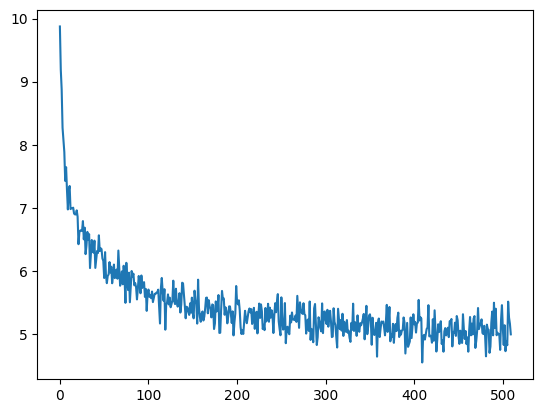

In [ ]:
import matplotlib.pyplot as plt

plt.plot(loss_total)
plt.show()

In [ ]:
model = main()

Loading data...
--------------------------------------------------
Dataset info:
Number of sessions: 113426
--------------------------------------------------
--------------------------------------------------
Dataset info:
Number of sessions: 12603
--------------------------------------------------
--------------------------------------------------
Dataset info:
Number of sessions: 13120
--------------------------------------------------
Complete load data!
complete load model!
Test: Recall@20: 0.2997, MRR@20: 0.1287


# Predict

In [ ]:
import numpy as np
i = np.random.randint(0, len(test_index[0]))
x = [test_index[0][i]]
y = [test_index[1][i]]
print('item indexes sequence input: ', x)
print('item index next output: ', y)

item indexes sequence input:  [[1207, 3730]]
item index next output:  [2716]


In [ ]:
test_data = RecSysDataset([x, y])
test_loader = DataLoader(test_data, batch_size = args['batch_size'], shuffle = False, collate_fn = collate_fn)

# Step 2: Dự báo các indice tiếp theo mà khách hàng có khả năng click
def _preddict(loader, model):
    model.eval()
    recalls = []
    mrrs = []
    j = 1
    with torch.no_grad():
      for seq, target, lens in loader:
        seq = seq.to(device)
        target = target.to(device)
        outputs = model(seq, lens)
        logits = F.softmax(outputs, dim = 1)
        _, indices = torch.topk(logits, 20, -1)
        print('Is next clicked item in top 20 suggestions: ', (target in indices))
        print('Top 20 next item indices suggested: ')
    return indices

_preddict(test_loader, model)

--------------------------------------------------
Dataset info:
Number of sessions: 1
--------------------------------------------------
Is next clicked item in top 20 suggestions:  False
Top 20 next item indices suggested: 


tensor([[ 196, 1929,  553, 2913, 2973,  766, 1954,  923,  606,  919,  410,  625,
          759, 1543,  175,  864, 3108,  358,  617, 2408]])